In [2]:
import json
import os
from benchmark.bechmark_results import ExperimentResult
import  numpy as np
from benchmark.benchmark_config import ExperimentConfig
from utils.math_utils import calculate_model_ranking
from utils.fs_utils import load_dataset
from tqdm import tqdm


In [3]:
def calculate_percentile_for_given_element(A, n):
    # Assume A is sorted
    
    # Get the index where n would be inserted in the sorted array to maintain order
    index = np.searchsorted(A, n, side='right')
    
    # Calculate the percentile
    percentile = (index / len(A)) * 100
    return percentile


def find_index_where_rest_are_one(A):
    # Iterate through the array
    for i in range(len(A)):
        # Check if all elements from the current index to the end are 1
        if np.all(A[i:] == 1):
            return i
    
    # If no such index exists, return the length of the array
    return len(A)


def calculate_row_percentiles(matrix):
    # Initialize an empty array to store percentiles with the same shape as the input matrix
    percentiles_matrix = np.zeros_like(matrix)
    
    # Loop through each row
    for i in range(matrix.shape[0]):
        # Sort the row
        sorted_row = np.sort(matrix[i])
        
        # Calculate percentiles for each element in the row
        percentiles_matrix[i] = [np.searchsorted(sorted_row, x, side='right') / len(matrix[i]) * 100 for x in matrix[i]]
    
    return percentiles_matrix

def calculate_percentiles(selected_accuracies, realisations_results):
    index_of_sorted_accuracies = 3 
    num_models = len(realisations_results[0][index_of_sorted_accuracies])
    percentiles = []
    for pool in range(len(selected_accuracies)):
        # Calculate percentiles for each element
        percentiles.append([(np.searchsorted(realisations_results[pool][index_of_sorted_accuracies], a, side='right') / num_models) * 100 for a in selected_accuracies[pool]])

    return np.array(percentiles)


def find_index_when_sure_of_best_model(array, max_values):
    # Initialize an empty list to store the result indices
    result_indices = []
    
    # Loop through each row in ACC
    for i in range(array.shape[0]):
        max_val = max_values[i]  # Get the max value for the current row
        row = array[i]        # Get the current row
        
        # Iterate through the row to find the index
        for j in range(len(row)):
            if row[j] == max_val and np.all(row[j:] == max_val):
                result_indices.append(j)
                break
        else:
            # If no such index is found, append -1 (or another marker if needed)
            result_indices.append(array.shape[0])
    
    return np.array(result_indices)


def calculate_90th_percentile_acc_gap(array):
    
    return  # just one 1D numpy arrat that is actually the 90th percentile of the accuracy gap
    


def find_index_where_all_after_greater_than(arr, threshold=0.9):
    # Iterate through the array to find the index
    for i in range(len(arr)):
        if np.all(arr[i:] >= threshold):
            return i
    return len(arr) #


def calculate_rankings(selected_accuracies, gt_accuracies):
    N, M = selected_accuracies.shape  # N: number of rows, M: number of columns
    rankings = np.zeros_like(selected_accuracies, dtype=int)  # Initialize the output array
    
    # list of dictionaries to store rankings of each accuracy
    ranking_dict = [{} for _ in range(N)]
    for i in range(N):
        current_val = None
        for j in range(len(gt_accuracies[i][2])):
            if current_val is None or current_val != gt_accuracies[i][2][j]:
                current_val = gt_accuracies[i][2][j]
                ranking_dict[i][current_val] = j
    
    # Iterate over each row
    for i in range(N):        
        # Assign ranks to the selected_accuracies based on the rank_dict
        for j in range(M):
            rankings[i, j] = ranking_dict[i][selected_accuracies[i, j]]
    
    return rankings


def compute_loss(pred, orac, num_models):

    """
    This function computes the weighted loss
    """

    # Replicate oracle realization
    orac_rep = np.matlib.repmat(orac.reshape(np.size(orac), 1), 1, num_models)

    # Compute errors
    errors = (pred != orac_rep)*1

    # Compute the weighted loss
    loss = np.mean(errors, axis=0)
    loss = np.squeeze(np.asarray(loss))

    return loss


def compute_agreements(pred, orac, num_models):
    """
    This function computes the agreements
    """
    # Replicate oracle realization
    orac_rep = np.matlib.repmat(orac.reshape(np.size(orac), 1), 1, num_models)

    # Compute errors
    true_pos = (pred == orac_rep) * 1

    # Compute the weighted loss
    agreements = np.sum(true_pos, axis=0)

    # Reduce the extra dimension
    agreements = np.squeeze(np.asarray(agreements))

    return agreements


def compute_posterior(predictions, oracle, realisations_results, res, method):
    num_models = predictions.shape[1]
    budget = res.iteration_results[method]["bestModelSelectedT"].shape[1]
    
    all_posteriors = []
    
    for ind, realisation  in enumerate(res.realisations):
        losses = np.zeros((budget, num_models))
        agreements = np.zeros((budget, num_models))
        post_ratio_method = np.zeros(budget)
        all_winners_method = np.zeros((budget, num_models))
        
        
        
        labelled_ins_real = np.array(res.iteration_results[method]["selectedDatapointT"][ind])
        
        for t in range(budget):
            losses[t, :] = compute_loss(predictions[labelled_ins_real[:t+1].astype(int), :], oracle[labelled_ins_real[:t+1].astype(int)], num_models)
            agreements[t, :] = compute_agreements(predictions[labelled_ins_real[:t+1].astype(int), :], oracle[labelled_ins_real[:t+1].astype(int)], num_models)

            arg_winners_t = np.where(np.equal(losses[t, :] .reshape(num_models, 1), np.min(losses[t, :] )))[0]  # Winners of the round B x M
            all_winners_method[t, arg_winners_t] += 1
            winner_t = arg_winners_t

            
            # If multi winners, choose randomly
            len_winners = np.size(arg_winners_t)
            if len_winners > 1:
                idx_winner_t = np.random.choice(len_winners, 1)
                winner_t = arg_winners_t[idx_winner_t]
    
            losses_t = t + 1 - agreements[t, :]         
            if len(np.unique(losses_t)) == 1:  # if all winners have the same loss, then both the log posterior and regret will be zero
                post_ratio_method[t] = 0
            else:  # if models have different losses:
                if len_winners > 1:  # if there are multi-winners, then choose a model among winners as the second best
                    post_ratio_method[t] = 0
                else:
                    loss_second_best_i = np.flip(sorted(set(losses_t)))[-2] # set the second winner loss to the second min loss
                    # Log Ratio of Posterior
                    post_ratio_method[t] = loss_second_best_i - losses_t[winner_t]
        all_posteriors.append(post_ratio_method)
        
        return np.mean(np.array(all_posteriors), axis=0)
            
        
def calculate_model_accuracies(predictions, oracle):
    accuracies = []

    orac = oracle.squeeze()
    # Loop over the predictions (assuming predictions is a 2D array where each row is a different set of predictions)
    for i in tqdm(range(predictions.shape[1])):
        # Compare the oracle with the i-th column of predictions and calculate the mean accuracy
        accuracy = np.mean(predictions[:, i] == orac)
        accuracies.append(accuracy)

    # Convert the accuracies list back to a NumPy array if needed
    accuracies = np.array(accuracies)
    return accuracies


In [50]:
import numpy.matlib

path = 'path'

one_shot_succ_prob = {}
accuracy_gap = {}
percentile90_acc_gap = {}
percentile95_acc_gap = {}
percentile100_acc_gap = {}
five_shot_succ_prob = {}
posterior_ratio = {}
model_accuracies = {}


for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    
    
    res_file = 'experiment_result_additional.json' if not "imagenet" in folder else 'experiment_result.json'
    
    with open(os.path.join(folder_path, res_file), 'r') as f:
        data = json.load(f)
    res = ExperimentResult.from_json(data)
    
    config = ExperimentConfig.from_json_file(os.path.join(folder_path, 'config.json'))
    
    oracle, predictions, classes = load_dataset(os.path.join('path', config.dataset_path))
    model_accuracies[folder] = calculate_model_accuracies(predictions, oracle)
    
    # get GT
    realisations_results = np.zeros(len(res.realisations), dtype=object)
    for i, r in enumerate(res.realisations):
        # this calculates the model ranking for each realization pool, returns a tuple of model ranking and accuracies
        # realisations_results[i]  = calculate_model_ranking(predictions[r], oracle[r])  # predictions[r] takes all predictions for that realization pool
        tmp = calculate_model_ranking(predictions[r], oracle[r]) 
        sorted_accuracies = np.sort(tmp[1])
        realisations_results[i] = *tmp, sorted_accuracies[::-1], sorted_accuracies
        
    one_shot_succ_prob[folder] = {}
    accuracy_gap[folder] = {}
    percentile90_acc_gap[folder] = {}
    percentile95_acc_gap[folder] = {}
    percentile100_acc_gap[folder] = {}
    five_shot_succ_prob[folder] = {}
    posterior_ratio[folder] = {}
    
    print(folder)
    res.global_best_accuracy = np.array(res.global_best_accuracy)
    for model_selection_algorithm in tqdm(res.iteration_results.keys()):
        # create numpy arrays from saved lists
        res.iteration_results[model_selection_algorithm]["bestModelSelectedT"] = np.array(res.iteration_results[model_selection_algorithm]["bestModelSelectedT"])
        res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"] = np.array(res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"])
        
        # get success probability
        success_probability = np.mean(res.iteration_results[model_selection_algorithm]["bestModelSelectedT"], axis=0).tolist()
        
        # five shot success probability
        rankings = calculate_rankings(res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"], realisations_results)
        five_shot_success_probability = rankings < 5
        five_shot_succ_prob[folder][model_selection_algorithm] = np.mean(five_shot_success_probability, axis=0).tolist()
        
        one_shot_succ_prob[folder][model_selection_algorithm] = success_probability
        
        # accuracy gap
        average_accuracy_gap = np.mean(res.global_best_accuracy[:, np.newaxis] - res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"], axis=0)
        accuracy_gap[folder][model_selection_algorithm] = average_accuracy_gap
    
        # 90th percentile accuracy gap
        acc_gap = res.global_best_accuracy[:, np.newaxis] - res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"]
        percentile_90 = np.quantile(acc_gap, 0.9, axis=0, method='nearest')
        percentile90_acc_gap[folder][model_selection_algorithm] = percentile_90
        percentile_95 = np.quantile(acc_gap, 0.95, axis=0, method='nearest')
        percentile95_acc_gap[folder][model_selection_algorithm] = percentile_95
        percentile_100 = np.quantile(acc_gap, 1.0, axis=0, method='nearest')
        percentile100_acc_gap[folder][model_selection_algorithm] = percentile_100
        
        # posterior ratio
        # posterior_ratio[folder][model_selection_algorithm] = compute_posterior(predictions=predictions, oracle=oracle, realisations_results=realisations_results, res=res, method=model_selection_algorithm)
        

INFO: Predictions are of type float64. Convert to int32.


100%|██████████| 109/109 [00:00<00:00, 99494.92it/s]


glue_cola


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


INFO: Predictions are of type float64. Convert to int32.


100%|██████████| 82/82 [00:00<00:00, 26560.58it/s]


glue_mnli


100%|██████████| 114/114 [00:00<00:00, 67043.00it/s]


imagenet_v2_top-images1k


100%|██████████| 6/6 [00:00<00:00, 32.04it/s]


INFO: Predictions are of type float64. Convert to int32.


100%|██████████| 97/97 [00:00<00:00, 93592.70it/s]


glue_sst2


100%|██████████| 114/114 [00:00<00:00, 70388.73it/s]


imagenet_v2_threshold-071k


100%|██████████| 6/6 [00:00<00:00, 31.38it/s]


INFO: Predictions are of type float64. Convert to int32.


100%|██████████| 90/90 [00:00<00:00, 39983.83it/s]


glue_qnli


100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


INFO: Predictions are of type float64. Convert to int32.


100%|██████████| 101/101 [00:00<00:00, 5303.40it/s]


glue_qqp


100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


INFO: Classes start at 1 instead of 0. Adjusting dataset.


100%|██████████| 102/102 [00:00<00:00, 4538.38it/s]


imagenet1k


100%|██████████| 30/30 [00:00<00:00, 61082.10it/s]


pacs


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


INFO: Predictions are of type float64. Convert to int32.


100%|██████████| 87/87 [00:00<00:00, 149184.16it/s]


glue_rte


100%|██████████| 80/80 [00:00<00:00, 52298.05it/s]


cifar10_4070


100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


INFO: Predictions are of type float64. Convert to int32.
INFO: Classes start at 1 instead of 0. Adjusting dataset.


100%|██████████| 9/9 [00:00<00:00, 28425.25it/s]


domain_drift


100%|██████████| 80/80 [00:00<00:00, 49917.33it/s]


cifar10_5592


100%|██████████| 114/114 [00:00<00:00, 81498.32it/s]


imagenet_v2_matched-frequency1k


100%|██████████| 6/6 [00:00<00:00, 31.49it/s]


INFO: Predictions are of type float64. Convert to int32.


100%|██████████| 8/8 [00:00<00:00, 23045.63it/s]


emotion_detection


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


INFO: Predictions are of type float64. Convert to int32.


100%|██████████| 95/95 [00:00<00:00, 140549.87it/s]


glue_mrpc


100%|██████████| 114/114 [00:00<00:00, 25329.80it/s]


imagenet_pytorch_models1k


100%|██████████| 6/6 [00:00<00:00, 32.66it/s]


INFO: Predictions are of type float64. Convert to int32.


100%|██████████| 118/118 [00:00<00:00, 177711.98it/s]


glue_wnli


100%|██████████| 6/6 [00:00<00:00, 23.60it/s]


# Find cutoff

In [51]:
second_best_cutoff = {}
for folder in one_shot_succ_prob.keys():
    second_best_cutoff[folder] = 10000000  # no budget this big
    for method in one_shot_succ_prob[folder].keys():
        if "Model" in method:
            continue
        ind = find_index_where_all_after_greater_than(np.array(one_shot_succ_prob[folder][method]), 1.0)
        second_best_cutoff[folder] = min(second_best_cutoff[folder], ind)
        
second_best_cutoff

{'glue_cola': 659,
 'glue_mnli': 974,
 'imagenet_v2_top-images1k': 568,
 'glue_sst2': 662,
 'imagenet_v2_threshold-071k': 683,
 'glue_qnli': 998,
 'glue_qqp': 4800,
 'imagenet1k': 781,
 'pacs': 548,
 'glue_rte': 84,
 'cifar10_4070': 981,
 'domain_drift': 708,
 'cifar10_5592': 888,
 'imagenet_v2_matched-frequency1k': 722,
 'emotion_detection': 185,
 'glue_mrpc': 326,
 'imagenet_pytorch_models1k': 546,
 'glue_wnli': 64}

# Plotting

In [603]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Use LaTeX for all text rendering
rc('text', usetex=True)

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

# Enable LaTeX for text rendering (pdflatex)
rc('text', usetex=True)

# Set the font to Times using the appropriate LaTeX package
rcParams['text.latex.preamble'] = r'''
    \usepackage{mathptmx}  % Use Times font for text and math
'''
        
import matplotlib.colors as mcolors
def make_pastel2(color, weight=0.5):
    color = np.array(mcolors.to_rgba(color))  # Ensure the color is in RGBA format
    white = np.array([1.0, 1.0, 1.0, 1.0])   # White color in RGBA
    pastel_color = color * weight + white * (1 - weight)
    return pastel_color
    
    
def plot_results_4x5(dictionary, y_title, filename, size=(8, 16),  cutoff=None, title_mapping=None, freq=1, arrow_line_index=None, arrow_label=None, confidence=0.9, xtick_mapping=None,
                 no_arrow=False):
    excluded_folders = ['domain_drift', 'glue_wnli']
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    red_color = mcolors.to_rgba('red')
    colors = plt.cm.Dark2(np.linspace(0, 1, 8))
    # colormapping = {'Random': make_pastel2(colors[0]),
    #                 'QBC Entropy': make_pastel2(colors[-3]),
    #                 'QBC Margin': make_pastel2(colors[2]),
    #                 "AMC": make_pastel2(colors[-1]),
    #                 "VMA": make_pastel2(colors[-2])
    #                 }
    colormapping = {'Random': make_pastel2(colors[0]),
                    'QBC Entropy': make_pastel2(colors[1]),
                    'QBC Margin': make_pastel2(colors[2]),
                    "AMC": make_pastel2(colors[3]),
                    "VMA": make_pastel2(colors[-4])
                    }
    
    markermapping = {'Random': 'o',
                    'QBC Entropy': 's',
                    'QBC Margin': 'd',
                    "AMC": '+',
                    "VMA": '*'
                    }
    
    linestylemapping = {'Random': ':',
                    'QBC Entropy': '--',
                    'QBC Margin': '--',
                    "AMC": '-.',
                    "VMA": '-.'
                    }

    # Create a 6-column by 3-row figure
    # fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    fig, axes = plt.subplots(4, 5, figsize=size)
        
    imagenet_epse = {
        'imagenet1k': 0.45,
        'imagenet_pytorch_models1k': 0.45,
        'imagenet_v2_matched-frequency1k': 0.48,
        'imagenet_v2_threshold-071k': 0.45,
        'imagenet_v2_top-images1k':  0.46
    }

    # Generate some dummy data
    lines = []
    labels = ['MODEL PICKER', 'RANDOM', 'UNCERTAINTY', 'MARGIN', 'AMC', 'VMA']
    labels = [r'\textsc{Model Picker}', r'\textsc{random}', r'\textsc{uncertainty}', r'\textsc{margin}', r'\textsc{amc}', r'\textsc{vma}']


    for i, (ax, folder) in enumerate(zip(axes.flatten(), title_mapping.keys())):
        for method in dictionary[folder].keys():
            # Plot 6 lines with different colors
            if 'domain_drift' in folder and '0.45' in method:
                continue       
            color = colormapping[method] if method in colormapping.keys() else make_pastel2(red_color, weight=0.8)
            marker = markermapping[method] if method in markermapping.keys() else 'x'
            linestyle = linestylemapping[method] if method in linestylemapping.keys() else '-'
            marker = None
            linestyle = None
            label = method if method in colormapping.keys() else 'ModelPicker'
            x = np.arange(len(dictionary[folder][method]))
            y = dictionary[folder][method]
            if cutoff is not None:
                x = np.arange(cutoff[folder])
                y = y[:cutoff[folder]]
            x = x[::freq]
            y = y[::freq]

            current_ticks = ax.get_xticks()

            # Define new ticks with twice the current number of ticks
            new_ticks = np.linspace(current_ticks.min(), current_ticks.max(), len(current_ticks) * 2)
            # print(list(current_ticks))
            # Set the new ticks
            if xtick_mapping is not None:
                ax.set_xticks(xtick_mapping[folder])
            # ax.set_xticks(new_ticks)
            
            # adjust ticks size
            # Adjust font size of ticks
            ax.tick_params(axis='x', labelsize=20)  # x-axis
            ax.tick_params(axis='y', labelsize=20)  # y-axis
            
            # less opaque plotbox
            for spine in ax.spines.values():
                spine.set_edgecolor('black')  # Set the color of the edge (spine)
                spine.set_alpha(0.25) 
            ax.grid(True, alpha=0.15, color='black', linestyle='--')
                        
            
            line, = ax.plot(x, y, color=color, label=label, alpha=0.9, linewidth=2.75) #@, marker=marker, markersize=2, linestyle=linestyle)
            # Store the lines to use in the legend
            if i == 0:
                lines.append(line)
                
            if "Model" in method:
                eps = method[-4:]
                if "image" in folder:
                    eps = imagenet_epse[folder]

        if arrow_line_index is not None and folder not in excluded_folders:
            print(folder)
            if not no_arrow:
                ax.plot([arrow_line_index[folder][0], arrow_line_index[folder][0]], [confidence, confidence], color='black', alpha=0.8)
                # Add arrows at both ends
                ax.annotate('', 
                    xy=(arrow_line_index[folder][1], confidence), 
                    xytext=(arrow_line_index[folder][0], confidence), 
                    arrowprops=dict(arrowstyle='<->', color='black', lw=0.4),
                    xycoords='data', textcoords='data')          
            mid_x = 0.9 * ((arrow_line_index[folder][0] + arrow_line_index[folder][1]) / 2)  # Calculate the midpoint
            
            # lab = f'{arrow_label[folder]:.1f}x'
            lab = rf'${arrow_label[folder]:.2f}\%$'
            
            ax.text(mid_x, confidence - 0.13, lab, ha='center', va='bottom', fontsize=28, fontweight='bold')

            
        ax.set_title(folder, fontsize=28, y=1.05)
        if title_mapping is not None:
            ax.set_title(title_mapping[folder], fontsize=28, y=1.05)
        ax.set_ylabel(y_title, fontsize=28)
        ax.set_xlabel('Labeling budget $b$', fontsize=28)

    # Create a shared legend at the bottom of the figure
    leg = fig.legend(lines, labels, loc='upper center', ncol=6, fontsize=30, bbox_to_anchor=(0.5, 1.07),)
    leg.legendHandles[0].set_color(make_pastel2(red_color, weight=0.8))  # Color for 'Line 1'
    leg.legendHandles[1].set_color(colormapping['Random']) 
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('white')

    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # Now adjust the vertical space manually with hspace
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # Leave 7% space at the top
    
    plt.savefig(filename,bbox_inches='tight')
    # save svg
    plt.savefig(filename.replace('.pdf', '.svg'),bbox_inches='tight')
    # Display the plot
    plt.show()

imagenet1k
imagenet_pytorch_models1k
imagenet_v2_matched-frequency1k
imagenet_v2_threshold-071k
imagenet_v2_top-images1k
pacs
cifar10_4070
cifar10_5592
emotion_detection
glue_cola
glue_mnli
glue_mrpc
glue_qnli
glue_qqp
glue_rte
glue_sst2


/tmp/ipykernel_13821/1772090169.py:569: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color(make_pastel2(red_color, weight=0.8))  # Color for 'Line 1'
/tmp/ipykernel_13821/1772090169.py:570: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color(colormapping['Random'])


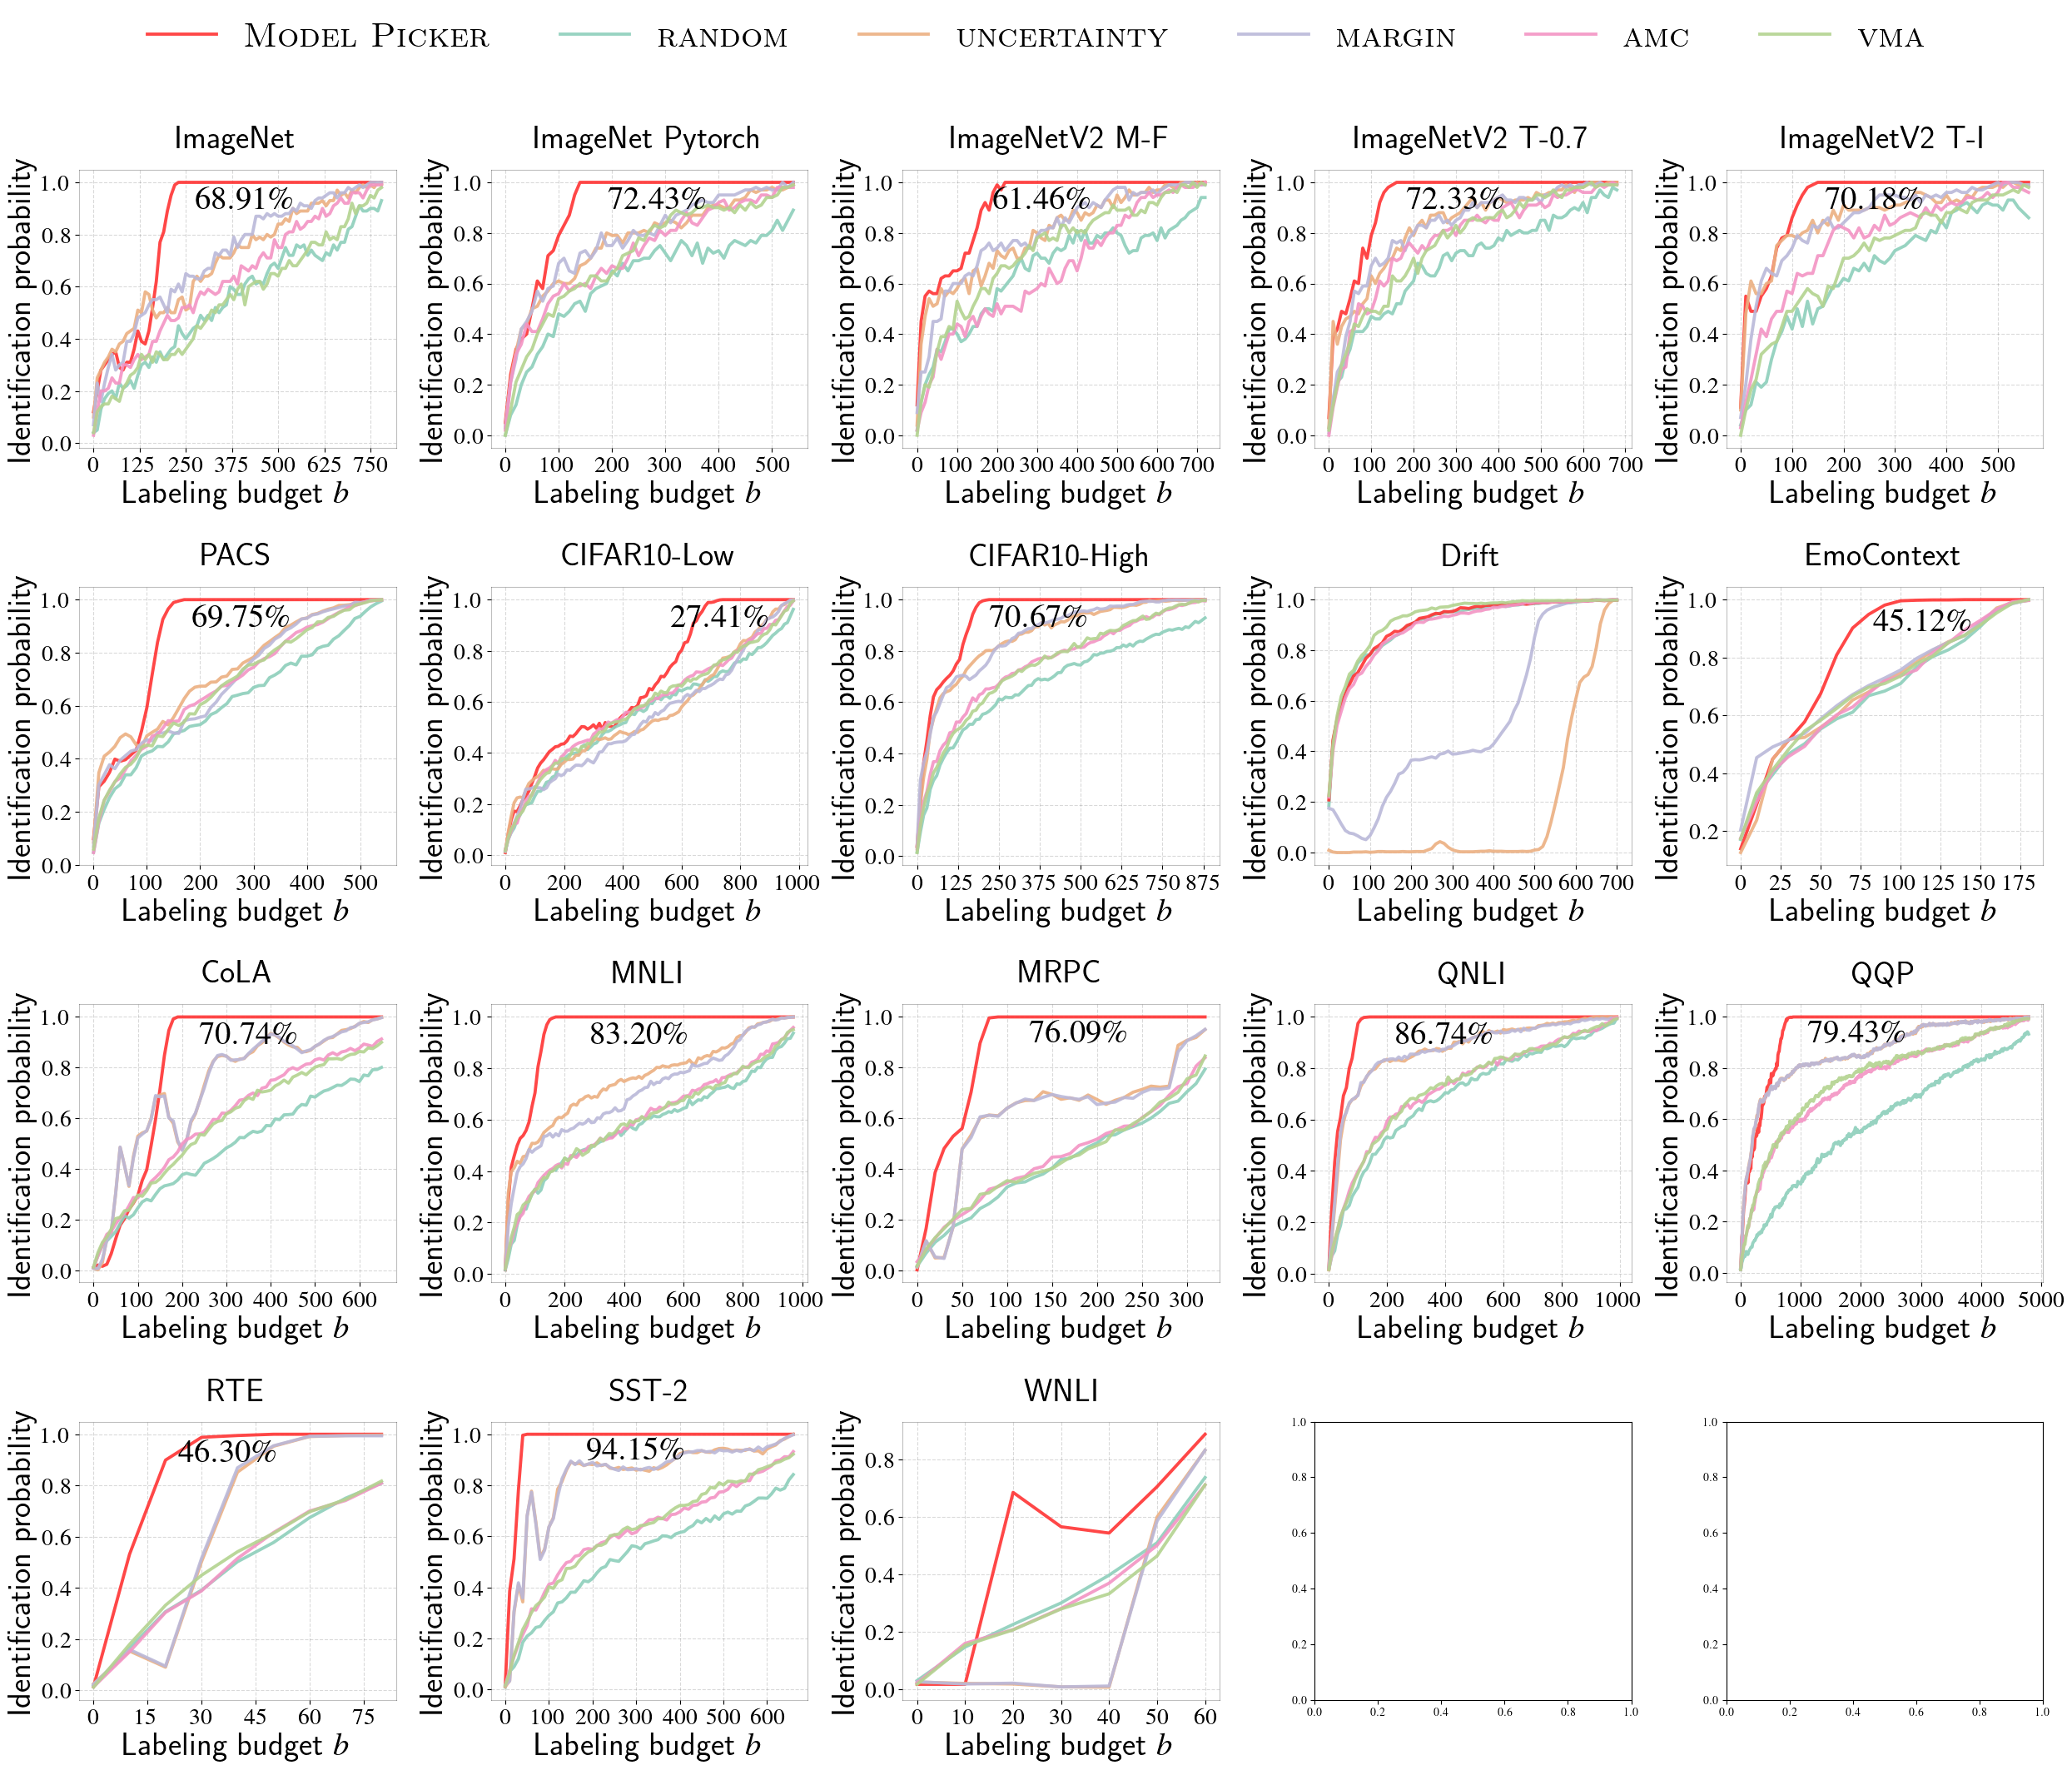

In [604]:
dataset_name_mapping = {
    'imagenet1k': 'ImageNet',
    'imagenet_pytorch_models1k': 'ImageNet Pytorch',
    'imagenet_v2_matched-frequency1k': 'ImageNetV2 M-F',
    'imagenet_v2_threshold-071k': 'ImageNetV2 T-0.7',
    'imagenet_v2_top-images1k': 'ImageNetV2 T-I',
    'pacs': 'PACS',
    'cifar10_4070': 'CIFAR10-Low',
    'cifar10_5592': 'CIFAR10-High',
    'domain_drift': 'Drift',
    'emotion_detection': 'EmoContext',
    'glue_cola': 'CoLA',
    'glue_mnli': 'MNLI',
    'glue_mrpc': 'MRPC',
    'glue_qnli': 'QNLI',
    'glue_qqp': 'QQP',
    'glue_rte': 'RTE',
    'glue_sst2': 'SST-2',
    'glue_wnli': 'WNLI'
}



dataset_xticks = {
    'imagenet1k': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'imagenet_pytorch_models1k': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'imagenet_v2_matched-frequency1k': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_threshold-071k': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_top-images1k': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'pacs': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'cifar10_4070':  [-250.0, 0.0, 200., 400.0, 600., 800.0, 1000.0],
    'cifar10_5592': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'domain_drift': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'emotion_detection': [-50.0, 0.0, 25.,  50.0, 75., 100.0, 125., 150.0, 175., 200.0],
    'glue_cola': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_mnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_mrpc': [-100.0, 0.0, 50., 100.0, 150., 200.0, 250., 300.0, 350., 400.0],
    'glue_qnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_qqp': [-2000.0, 0.0, 1000., 2000.0, 3000., 4000.0, 5000., 6000.0],
    'glue_rte': [-25.0, 0.0, 15.0, 30., 45.0, 60.0, 75., 90., 100.0],
    'glue_sst2': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_wnli': [-20.0, 0.0, 10., 20.0, 30., 40.0, 50., 60.0, 70., 80.0]
}

# plot_results(one_shot_succ_prob, 'Identification probability', 'success_probability_vertical10_nosquare_patel.pdf', size=(12, 16), cutoff=second_best_cutoff, title_mapping=dataset_name_mapping, freq=10,
#              arrow_line_index=arrow_line_index, arrow_label=arrow_label_percentrage, confidence=CONFIDENCE)

# plot_results_3x6(one_shot_succ_prob, 'Identification probability', 'succ_prob_3x6.pdf', size=(24, 12), cutoff=second_best_cutoff, title_mapping=dataset_name_mapping, freq=10,
#              arrow_line_index=arrow_line_index, arrow_label=arrow_label_percentrage, confidence=CONFIDENCE, xtick_mapping=dataset_xticks,
#              no_arrow=True)

plot_results_4x5(one_shot_succ_prob, 'Identification probability', 'succ_prob_4x5_LEGEND.pdf', size=(25, 21), cutoff=second_best_cutoff, title_mapping=dataset_name_mapping, freq=10,
             arrow_line_index=arrow_line_index, arrow_label=arrow_label_percentrage, confidence=CONFIDENCE, xtick_mapping=dataset_xticks,
             no_arrow=True)

# Plot model accuracies

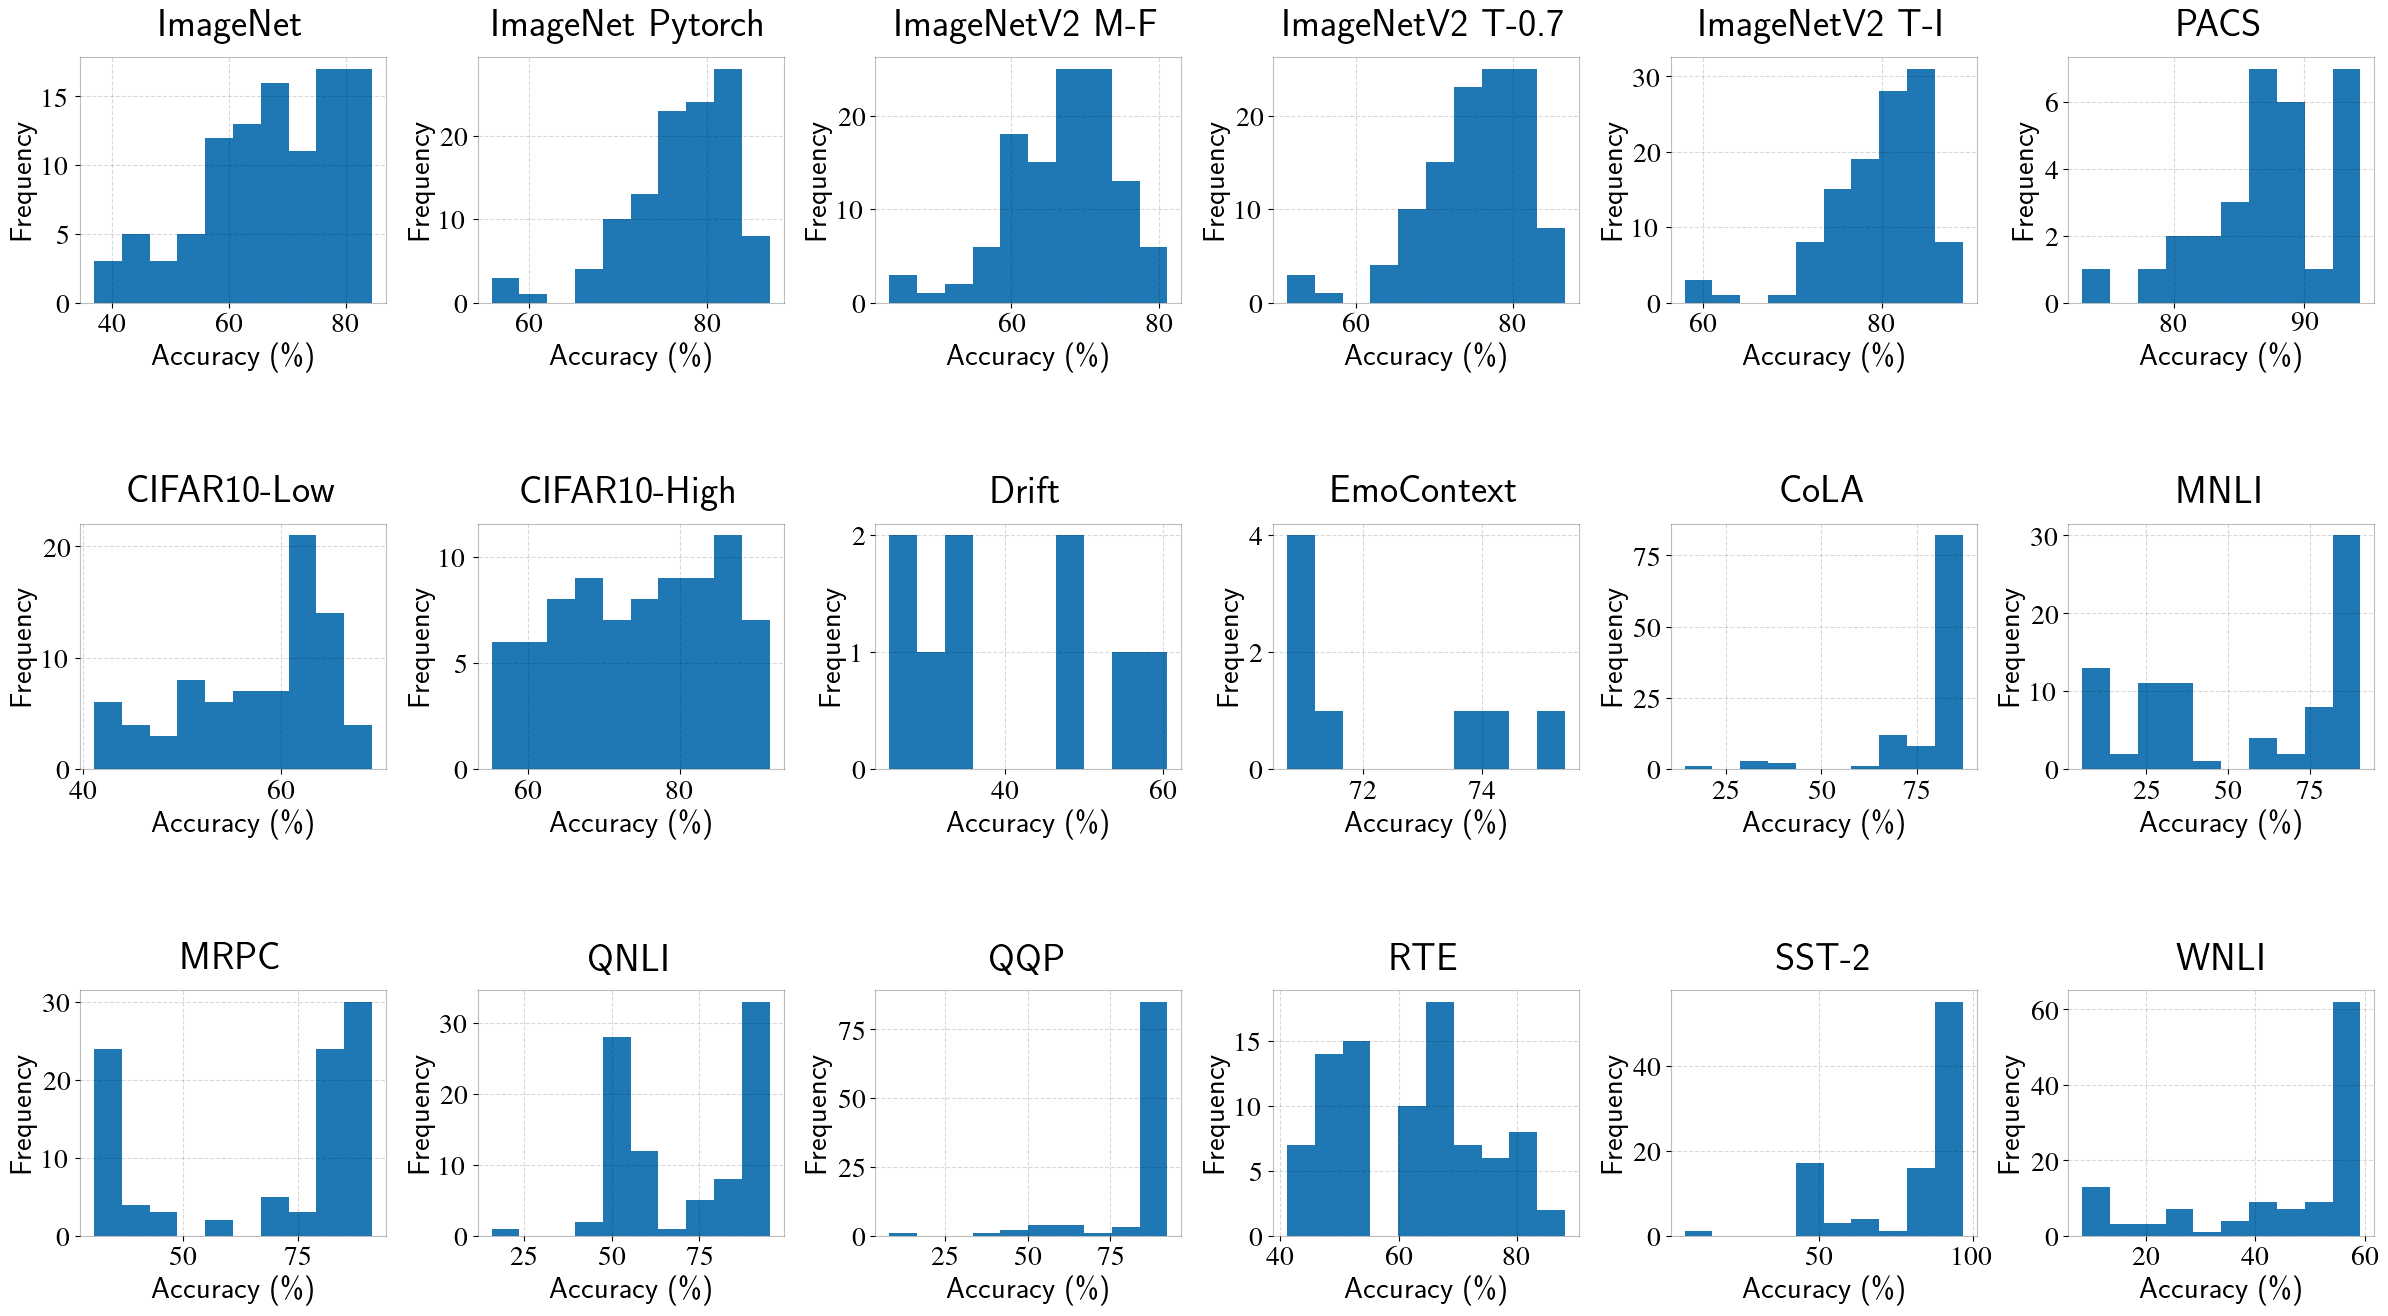

In [33]:
import matplotlib.pyplot as plt
from matplotlib import rc

# Use LaTeX for all text rendering
rc('text', usetex=True)

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

# Enable LaTeX for text rendering (pdflatex)
rc('text', usetex=True)

# Set the font to Times using the appropriate LaTeX package
rcParams['text.latex.preamble'] = r'''
    \usepackage{mathptmx}  % Use Times font for text and math
'''

def plot_model_accuracy_histogram(dictionary, y_title, filename, size=(8, 16), title_mapping=None, ):
    fig, axes = plt.subplots(3, 6, figsize=size)


    for i, (ax, folder) in enumerate(zip(axes.flatten(), title_mapping.keys())):

        ax.tick_params(axis='x', labelsize=20)  # x-axis
        ax.tick_params(axis='y', labelsize=20)  # y-axis
            
        # less opaque plotbox
        for spine in ax.spines.values():
            spine.set_edgecolor('black')  # Set the color of the edge (spine)
            spine.set_alpha(0.25) 
        ax.grid(True, alpha=0.15, color='black', linestyle='--')            
            
        x = dictionary[folder] * 100
        ax.hist(x, bins=10)

            
        ax.set_title(folder, fontsize=22, y=1.05)
        if title_mapping is not None:
            ax.set_title(title_mapping[folder], fontsize=28, y=1.05)
        ax.set_ylabel(y_title, fontsize=22)
        ax.set_xlabel('Accuracy (\%)', fontsize=22)

    # Use tight_layout to ensure subplots fit in the figure area
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # Now adjust the vertical space manually with hspace
    plt.subplots_adjust(hspace=0.9, wspace=0.3)
    
    # plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # Leave 7% space at the top
    
    plt.savefig(filename,bbox_inches='tight')
    # save svg
    plt.savefig(filename.replace('.pdf', '.svg'),bbox_inches='tight')
    # Display the plot
    plt.show()
    

dataset_name_mapping = {
    'imagenet1k': 'ImageNet',
    'imagenet_pytorch_models1k': 'ImageNet Pytorch',
    'imagenet_v2_matched-frequency1k': 'ImageNetV2 M-F',
    'imagenet_v2_threshold-071k': 'ImageNetV2 T-0.7',
    'imagenet_v2_top-images1k': 'ImageNetV2 T-I',
    'pacs': 'PACS',
    'cifar10_4070': 'CIFAR10-Low',
    'cifar10_5592': 'CIFAR10-High',
    'domain_drift': 'Drift',
    'emotion_detection': 'EmoContext',
    'glue_cola': 'CoLA',
    'glue_mnli': 'MNLI',
    'glue_mrpc': 'MRPC',
    'glue_qnli': 'QNLI',
    'glue_qqp': 'QQP',
    'glue_rte': 'RTE',
    'glue_sst2': 'SST-2',
    'glue_wnli': 'WNLI'
}


plot_model_accuracy_histogram(model_accuracies, 'Frequency', 'model_accuracies.pdf', size=(24, 14), title_mapping=dataset_name_mapping,)

# Epsilon appendix plotting

In [6]:
# load data

def get_epsilon_results(path):
    epsilon_success_prob = {}

    for folder in os.listdir(path):
        epsilon_success_prob[folder] = {}
        folder_path = os.path.join(path, folder)
        
        if folder.startswith('OLD'):
            continue
        
        res_file = 'experiment_result.json'
        
        with open(os.path.join(folder_path, res_file), 'r') as f:
            data = json.load(f)
        res = ExperimentResult.from_json(data)            
        
        print(folder)
        res.global_best_accuracy = np.array(res.global_best_accuracy)
        for model_selection_algorithm in tqdm(res.iteration_results.keys()):
            # create numpy arrays from saved lists
            res.iteration_results[model_selection_algorithm]["bestModelSelectedT"] = np.array(res.iteration_results[model_selection_algorithm]["bestModelSelectedT"])
            res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"] = np.array(res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"])
            
            # get success probability
            epsilon_success_prob[folder][model_selection_algorithm] = np.mean(res.iteration_results[model_selection_algorithm]["bestModelSelectedT"], axis=0).tolist()
    return epsilon_success_prob

gt_epsilon_success_prob = get_epsilon_results(path='path')

nois_epsilon_success_prob = get_epsilon_results(path='path')

gridsearch_imagenet_vote_finegrained


100%|██████████| 16/16 [00:00<00:00, 83.98it/s]


gridsearch_pacs_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 65.27it/s]


gridsearch_domain_drift_vote_finegrained_2024-10-14_09-51-24


100%|██████████| 16/16 [00:00<00:00, 21.16it/s]


gridsearch_imagenet_v2_top-images_vote_finegrained


100%|██████████| 16/16 [00:00<00:00, 81.28it/s]


gridsearch_emotion_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 16.75it/s]


gridsearch_glue_cola_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 20.49it/s]


gridsearch_cifar10_4070_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 16.08it/s]


gridsearch_imagenet_pytorch_models_vote_finegrained


100%|██████████| 16/16 [00:00<00:00, 16.60it/s]


gridsearch_glue_qnli_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 15.92it/s]


gridsearch_imagenet_v2_matched-frequency_vote_finegrained


100%|██████████| 16/16 [00:00<00:00, 80.79it/s]


gridsearch_glue_rte_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 59.83it/s]


gridsearch_glue_mnli_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 16.47it/s]


gridsearch_glue_qqp_vote_finegrained


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


gridsearch_glue_mrpc_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 34.90it/s]


gridsearch_cifar10_5592_vote_finegrained


100%|██████████| 15/15 [00:01<00:00, 13.78it/s]


gridsearch_glue_sst2_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 19.67it/s]


gridsearch_imagenet_v2_threshold-07_vote_finegrained


100%|██████████| 16/16 [00:00<00:00, 69.29it/s]


gridsearch_glue_wnli_vote_finegrained


100%|██████████| 15/15 [00:00<00:00, 196.83it/s]


gridsearch_glue_wnli_vote_finegrained_2024-09-24_03-32-14


100%|██████████| 15/15 [00:00<00:00, 204.59it/s]


gridsearch_imagenet_v2_matched-frequency_vote_finegrained_2024-09-24_14-06-22


100%|██████████| 16/16 [00:00<00:00, 72.53it/s]


gridsearch_glue_qnli_vote_finegrained_2024-09-24_03-40-09


100%|██████████| 15/15 [00:01<00:00, 14.53it/s]


gridsearch_glue_cola_vote_finegrained_2024-09-24_03-46-35


100%|██████████| 15/15 [00:00<00:00, 15.21it/s]


gridsearch_imagenet_pytorch_models_vote_finegrained_2024-09-25_11-56-18


100%|██████████| 16/16 [00:01<00:00, 14.53it/s]


gridsearch_cifar10_5592_vote_finegrained_2024-09-24_04-26-32


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


gridsearch_glue_mrpc_vote_finegrained_2024-09-24_03-35-00


100%|██████████| 15/15 [00:00<00:00, 40.53it/s]


gridsearch_domain_drift_vote_finegrained


100%|██████████| 16/16 [00:00<00:00, 20.18it/s]


gridsearch_pacs_vote_finegrained_2024-09-24_03-33-11


100%|██████████| 15/15 [00:00<00:00, 72.81it/s]


gridsearch_glue_sst2_vote_finegrained_2024-09-24_03-42-57


100%|██████████| 15/15 [00:00<00:00, 20.49it/s]


gridsearch_cifar10_4070_vote_finegrained_2024-09-24_04-36-53


100%|██████████| 15/15 [00:00<00:00, 15.25it/s]


gridsearch_imagenet_vote_finegrained_2024-09-24_15-17-08


100%|██████████| 16/16 [00:00<00:00, 70.01it/s]


gridsearch_imagenet_v2_threshold-07_vote_finegrained_2024-09-24_12-10-18


100%|██████████| 16/16 [00:00<00:00, 71.55it/s]


gridsearch_imagenet_v2_top-images_vote_finegrained_2024-09-24_10-54-41


100%|██████████| 16/16 [00:00<00:00, 69.18it/s]


gridsearch_glue_rte_vote_finegrained_2024-09-24_03-33-51


100%|██████████| 15/15 [00:00<00:00, 55.82it/s]


gridsearch_glue_qqp_vote_finegrained_2024-09-24_13-23-57


100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


gridsearch_glue_mnli_vote_finegrained_2024-09-24_03-42-46


100%|██████████| 15/15 [00:01<00:00, 14.53it/s]


gridsearch_emotion_vote_finegrained_2024-09-24_03-33-03


100%|██████████| 15/15 [00:01<00:00, 14.60it/s]


In [195]:
# plotting
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as mcolors

# Use LaTeX for all text rendering
rc('text', usetex=True)

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

# Enable LaTeX for text rendering (pdflatex)
rc('text', usetex=True)

# Set the font to Times using the appropriate LaTeX package
rcParams['text.latex.preamble'] = r'''
    \usepackage{mathptmx}  % Use Times font for text and math
'''

def make_pastel2(color, weight=0.5):
    color = np.array(mcolors.to_rgba(color))  # Ensure the color is in RGBA format
    white = np.array([1.0, 1.0, 1.0, 1.0])   # White color in RGBA
    pastel_color = color * weight + white * (1 - weight)
    return pastel_color

def plot_results_epsilon(dictionary, y_title, filename, size=(8, 16), title_mapping=None, freq=1,  xtick_mapping=None, cutoff=None, colormapping=None, epsilon_range=None, labels=None):

    # Create a 6-column by 3-row figure
    # fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    fig, axes = plt.subplots(4, 5, figsize=size)

    # Generate some dummy data
    lines = []

    for i, (ax, folder_key) in enumerate(zip(axes.flatten(), title_mapping.keys())):
        folder_title = None
        for key in dictionary.keys():
            if folder_key in key:
                folder = key
                folder_title = title_mapping[folder_key]
            
        print(folder, folder_title)
        for method in dictionary[folder].keys():
            # Plot 6 lines with different colors
            try:
                current_eps = str(float(method.split('_')[-1]))
            except Exception as e:
                print(f'{method} cannot get epsilon from it.')
                continue
            
            if current_eps not in epsilon_range:
                continue
 
            color = colormapping[current_eps]           
            
            x = np.arange(len(dictionary[folder][method]))
            y = dictionary[folder][method]
            if cutoff is not None:
                cutoff_key = folder_key
                if 'imagenet' in folder_key:
                    cutoff_key += '1k'
                if 'emotion' in folder_key:
                    cutoff_key = 'emotion_detection'
                x = np.arange(cutoff[cutoff_key])
                y = y[:cutoff[cutoff_key]]
                
            x = x[::freq]
            y = y[::freq]

            if xtick_mapping is not None:
                ax.set_xticks(xtick_mapping[folder_key])
            
            # adjust ticks size
            # Adjust font size of ticks
            ax.tick_params(axis='x', labelsize=20)  # x-axis
            ax.tick_params(axis='y', labelsize=20)  # y-axis
            
            # less opaque plotbox
            for spine in ax.spines.values():
                spine.set_edgecolor('black')  # Set the color of the edge (spine)
                spine.set_alpha(0.25) 
            ax.grid(True, alpha=0.15, color='black', linestyle='--')         
               
            label = labels[current_eps]
            line, = ax.plot(x, y, color=color, label=label, alpha=0.9, linewidth=2.75) #@, marker=marker, markersize=2, linestyle=linestyle)
            # Store the lines to use in the legend
            if 'domain' in folder_key: #i == 0:
                lines.append(line)
            
        # ax.set_title(folder, fontsize=28, y=1.05)
        ax.set_title(folder_title, fontsize=28, y=1.05)
        ax.set_ylabel(y_title, fontsize=28)
        ax.set_xlabel('Labeling budget $b$', fontsize=28)

    # Create a shared legend at the bottom of the figure
    leg = fig.legend(lines, labels.values(), loc='upper center', ncol=5, fontsize=30, bbox_to_anchor=(0.5, 1.07),)

    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('white')


    # Use tight_layout to ensure subplots fit in the figure area
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # Now adjust the vertical space manually with hspace
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # Leave 7% space at the top
    
    plt.savefig(filename,bbox_inches='tight')
    # save svg
    plt.savefig(filename.replace('.pdf', '.svg'),bbox_inches='tight')
    # Display the plot
    plt.show()

gridsearch_imagenet_v2_threshold-07_vote_finegrained ImageNet
Random cannot get epsilon from it.
gridsearch_imagenet_pytorch_models_vote_finegrained ImageNet Pytorch
Random cannot get epsilon from it.
gridsearch_imagenet_v2_matched-frequency_vote_finegrained ImageNetV2 M-F
Random cannot get epsilon from it.
gridsearch_imagenet_v2_threshold-07_vote_finegrained ImageNetV2 T-0.7
Random cannot get epsilon from it.
gridsearch_imagenet_v2_top-images_vote_finegrained ImageNetV2 T-I
Random cannot get epsilon from it.
gridsearch_pacs_vote_finegrained PACS
gridsearch_cifar10_4070_vote_finegrained CIFAR10-Low
gridsearch_cifar10_5592_vote_finegrained CIFAR10-High
gridsearch_domain_drift_vote_finegrained_2024-10-14_09-51-24 Drift
gridsearch_emotion_vote_finegrained EmoContext
gridsearch_glue_cola_vote_finegrained CoLA
gridsearch_glue_mnli_vote_finegrained MNLI
gridsearch_glue_mrpc_vote_finegrained MRPC
gridsearch_glue_qnli_vote_finegrained QNLI
gridsearch_glue_qqp_vote_finegrained QQP
gridsearch_gl

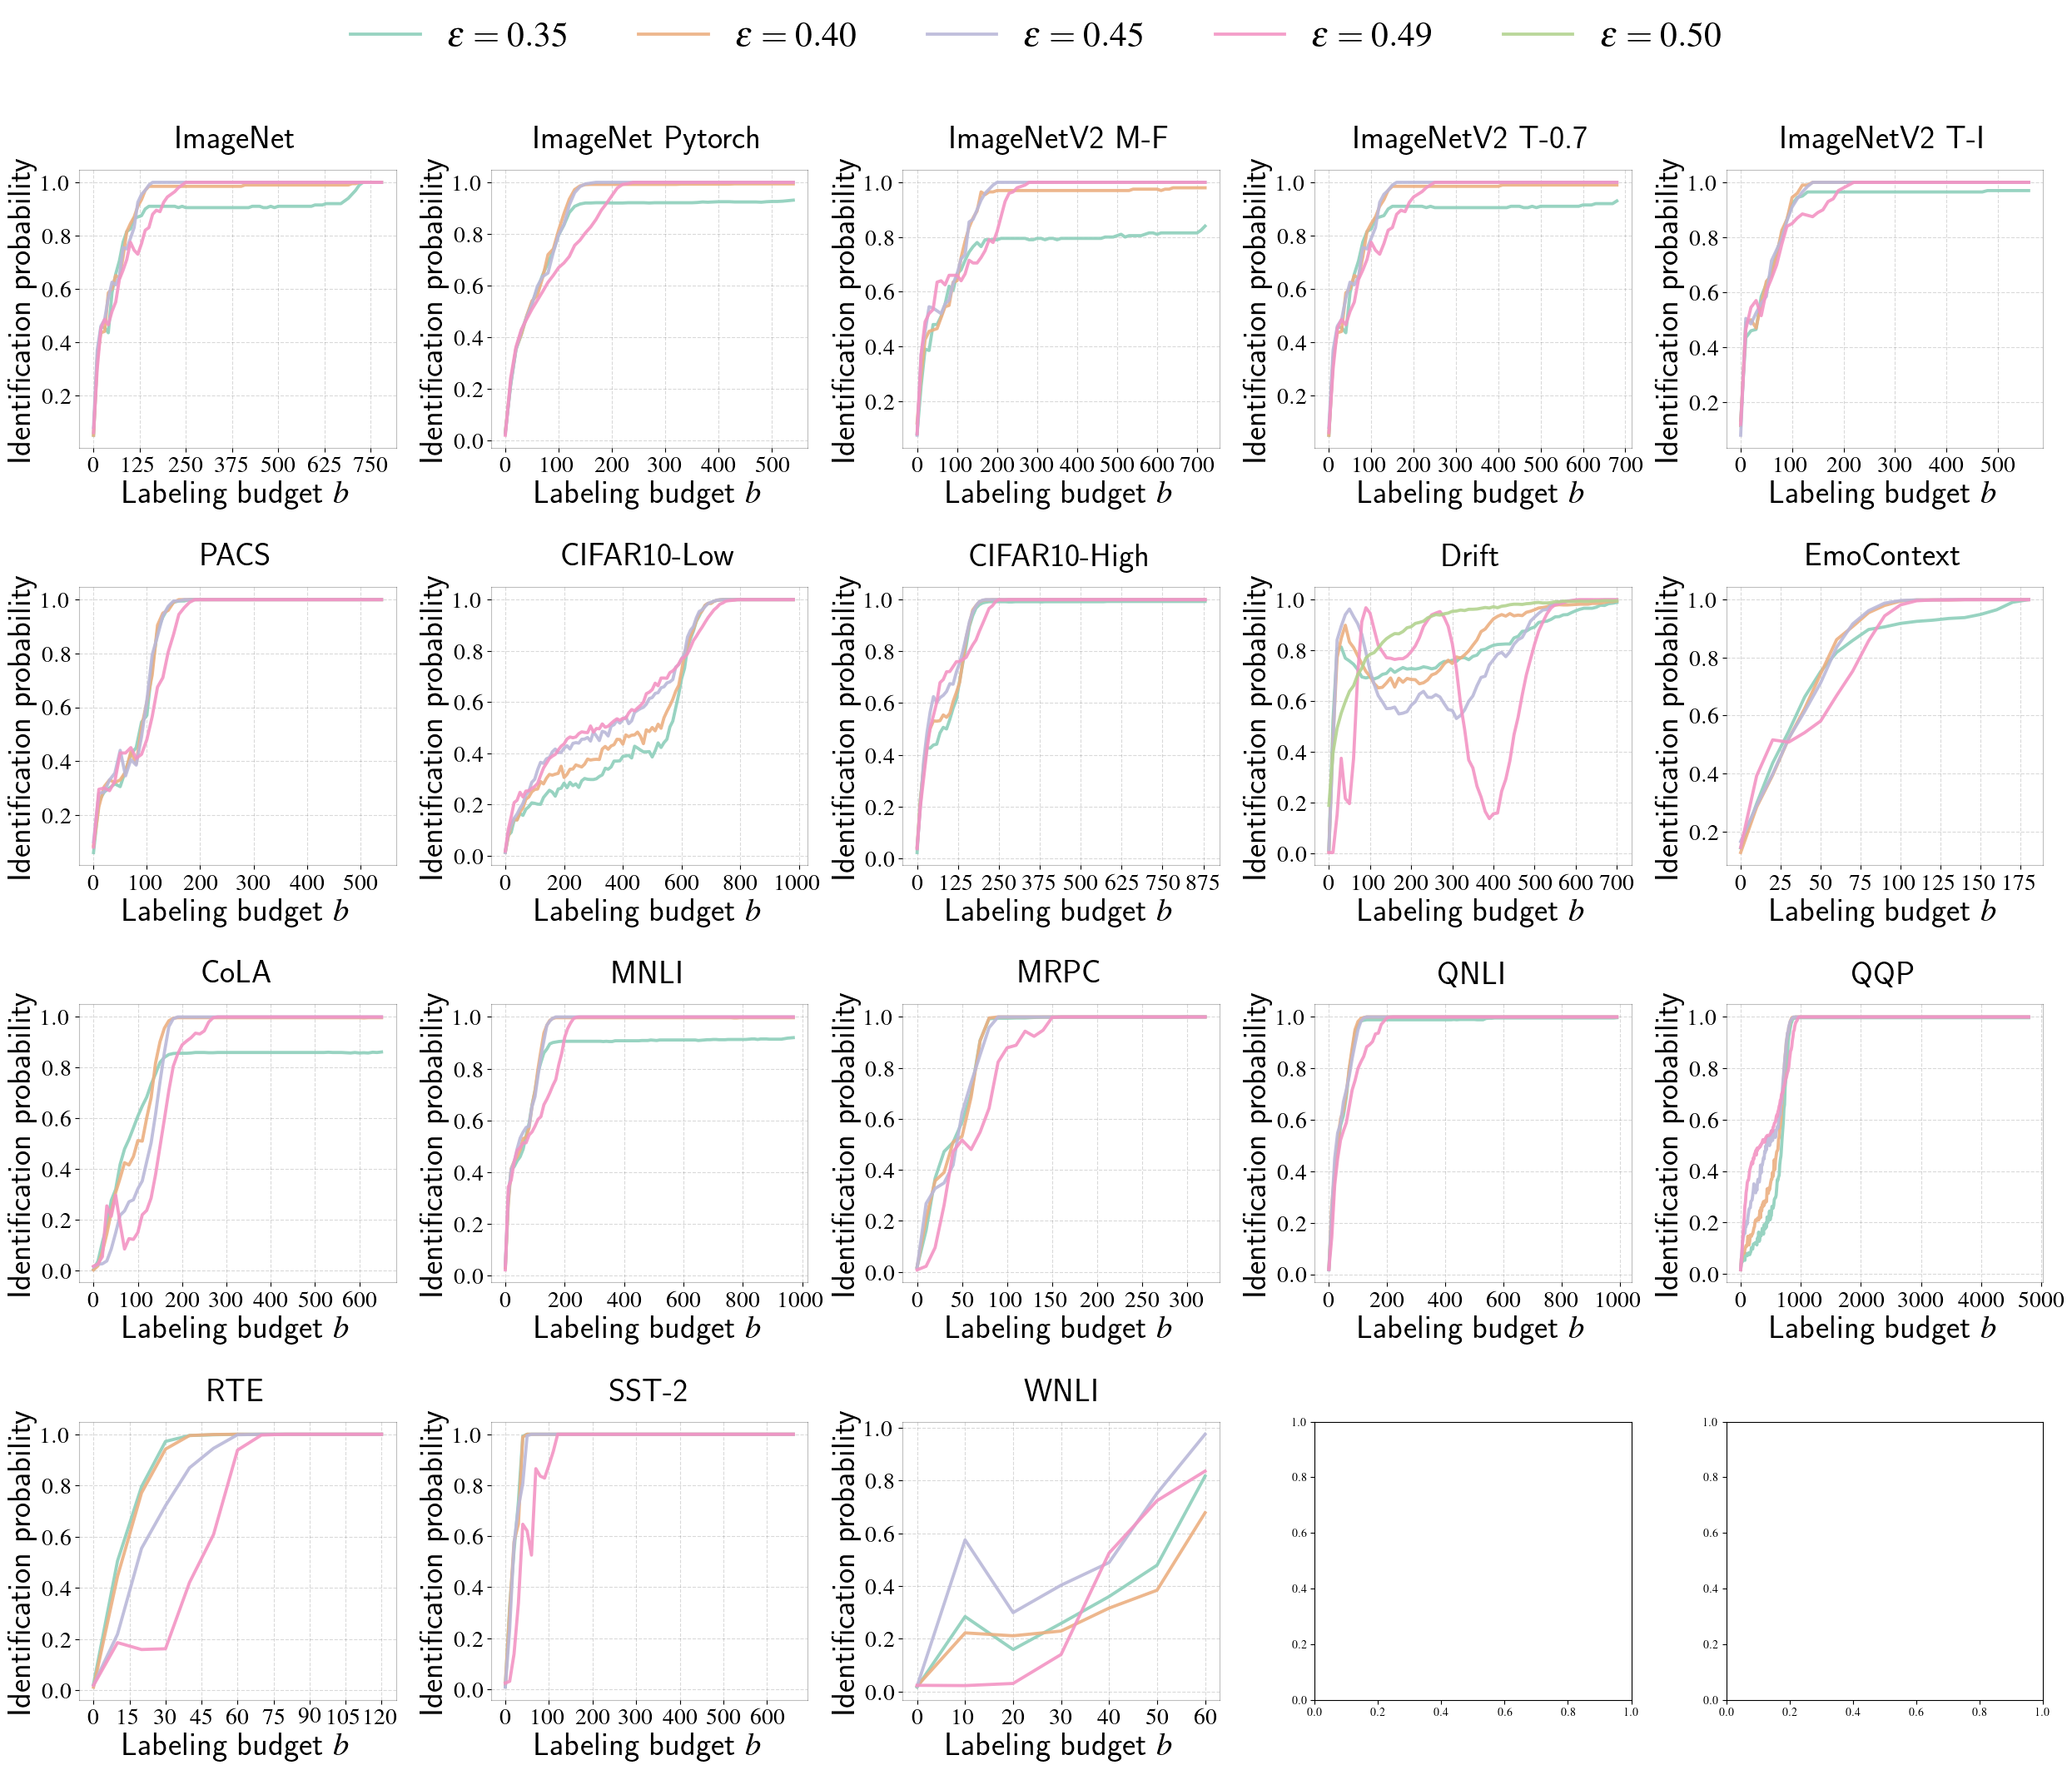

In [197]:
# GT

colors = plt.cm.Dark2(np.linspace(0, 1, 8))
epsilon_range = ['0.35', '0.4', '0.45', '0.49', '0.5']
colormapping = {epsilon_range[0]: make_pastel2(colors[0]),
                epsilon_range[1]: make_pastel2(colors[1]),
                epsilon_range[2]: make_pastel2(colors[2]),
                epsilon_range[3]: make_pastel2(colors[3]),
                epsilon_range[4]: make_pastel2(colors[-4])}

labels = {epsilon_range[0]: r'$\epsilon = 0.35$', 
          epsilon_range[1]: r'$\epsilon = 0.40$',
          epsilon_range[2]: r'$\epsilon = 0.45$',
          epsilon_range[3]: r'$\epsilon = 0.49$',
          epsilon_range[4]: r'$\epsilon = 0.50$'}

dataset_name_mapping = {
    'imagenet': 'ImageNet',
    'imagenet_pytorch_models': 'ImageNet Pytorch',
    'imagenet_v2_matched-frequency': 'ImageNetV2 M-F',
    'imagenet_v2_threshold-07': 'ImageNetV2 T-0.7',
    'imagenet_v2_top-images': 'ImageNetV2 T-I',
    'pacs': 'PACS',
    'cifar10_4070': 'CIFAR10-Low',
    'cifar10_5592': 'CIFAR10-High',
    'domain_drift': 'Drift',
    'emotion': 'EmoContext',
    'glue_cola': 'CoLA',
    'glue_mnli': 'MNLI',
    'glue_mrpc': 'MRPC',
    'glue_qnli': 'QNLI',
    'glue_qqp': 'QQP',
    'glue_rte': 'RTE',
    'glue_sst2': 'SST-2',
    'glue_wnli': 'WNLI'
}

dataset_xticks = {
    'imagenet': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'imagenet_pytorch_models': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'imagenet_v2_matched-frequency': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_threshold-07': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_top-images': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'pacs': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'cifar10_4070':  [-250.0, 0.0, 200., 400.0, 600., 800.0, 1000.0],
    'cifar10_5592': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'domain_drift': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'emotion': [-50.0, 0.0, 25.,  50.0, 75., 100.0, 125., 150.0, 175., 200.0],
    'glue_cola': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_mnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_mrpc': [-100.0, 0.0, 50., 100.0, 150., 200.0, 250., 300.0, 350., 400.0],
    'glue_qnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_qqp': [-2000.0, 0.0, 1000., 2000.0, 3000., 4000.0, 5000., 6000.0],
    'glue_rte': [-25.0, 0.0, 15.0, 30., 45.0, 60.0, 75., 90., 105., 120., 135.],
    'glue_sst2': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_wnli': [-20.0, 0.0, 10., 20.0, 30., 40.0, 50., 60.0, 70., 80.0]
}

plot_results_epsilon(gt_epsilon_success_prob, 'Identification probability', 'gt_epsilon_coarse.pdf', size=(25, 21), title_mapping=dataset_name_mapping, freq=10,
             xtick_mapping=dataset_xticks, labels=labels, epsilon_range=epsilon_range, colormapping=colormapping,
             cutoff=second_best_cutoff)

gridsearch_imagenet_v2_top-images_vote_finegrained_2024-09-24_10-54-41 ImageNet
Random cannot get epsilon from it.
gridsearch_imagenet_pytorch_models_vote_finegrained_2024-09-25_11-56-18 ImageNet Pytorch
Random cannot get epsilon from it.
gridsearch_imagenet_v2_matched-frequency_vote_finegrained_2024-09-24_14-06-22 ImageNetV2 M-F
Random cannot get epsilon from it.
gridsearch_imagenet_v2_threshold-07_vote_finegrained_2024-09-24_12-10-18 ImageNetV2 T-0.7
Random cannot get epsilon from it.
gridsearch_imagenet_v2_top-images_vote_finegrained_2024-09-24_10-54-41 ImageNetV2 T-I
Random cannot get epsilon from it.
gridsearch_pacs_vote_finegrained_2024-09-24_03-33-11 PACS
gridsearch_cifar10_4070_vote_finegrained_2024-09-24_04-36-53 CIFAR10-Low
gridsearch_cifar10_5592_vote_finegrained_2024-09-24_04-26-32 CIFAR10-High
gridsearch_domain_drift_vote_finegrained Drift
gridsearch_emotion_vote_finegrained_2024-09-24_03-33-03 EmoContext
gridsearch_glue_cola_vote_finegrained_2024-09-24_03-46-35 CoLA
grids

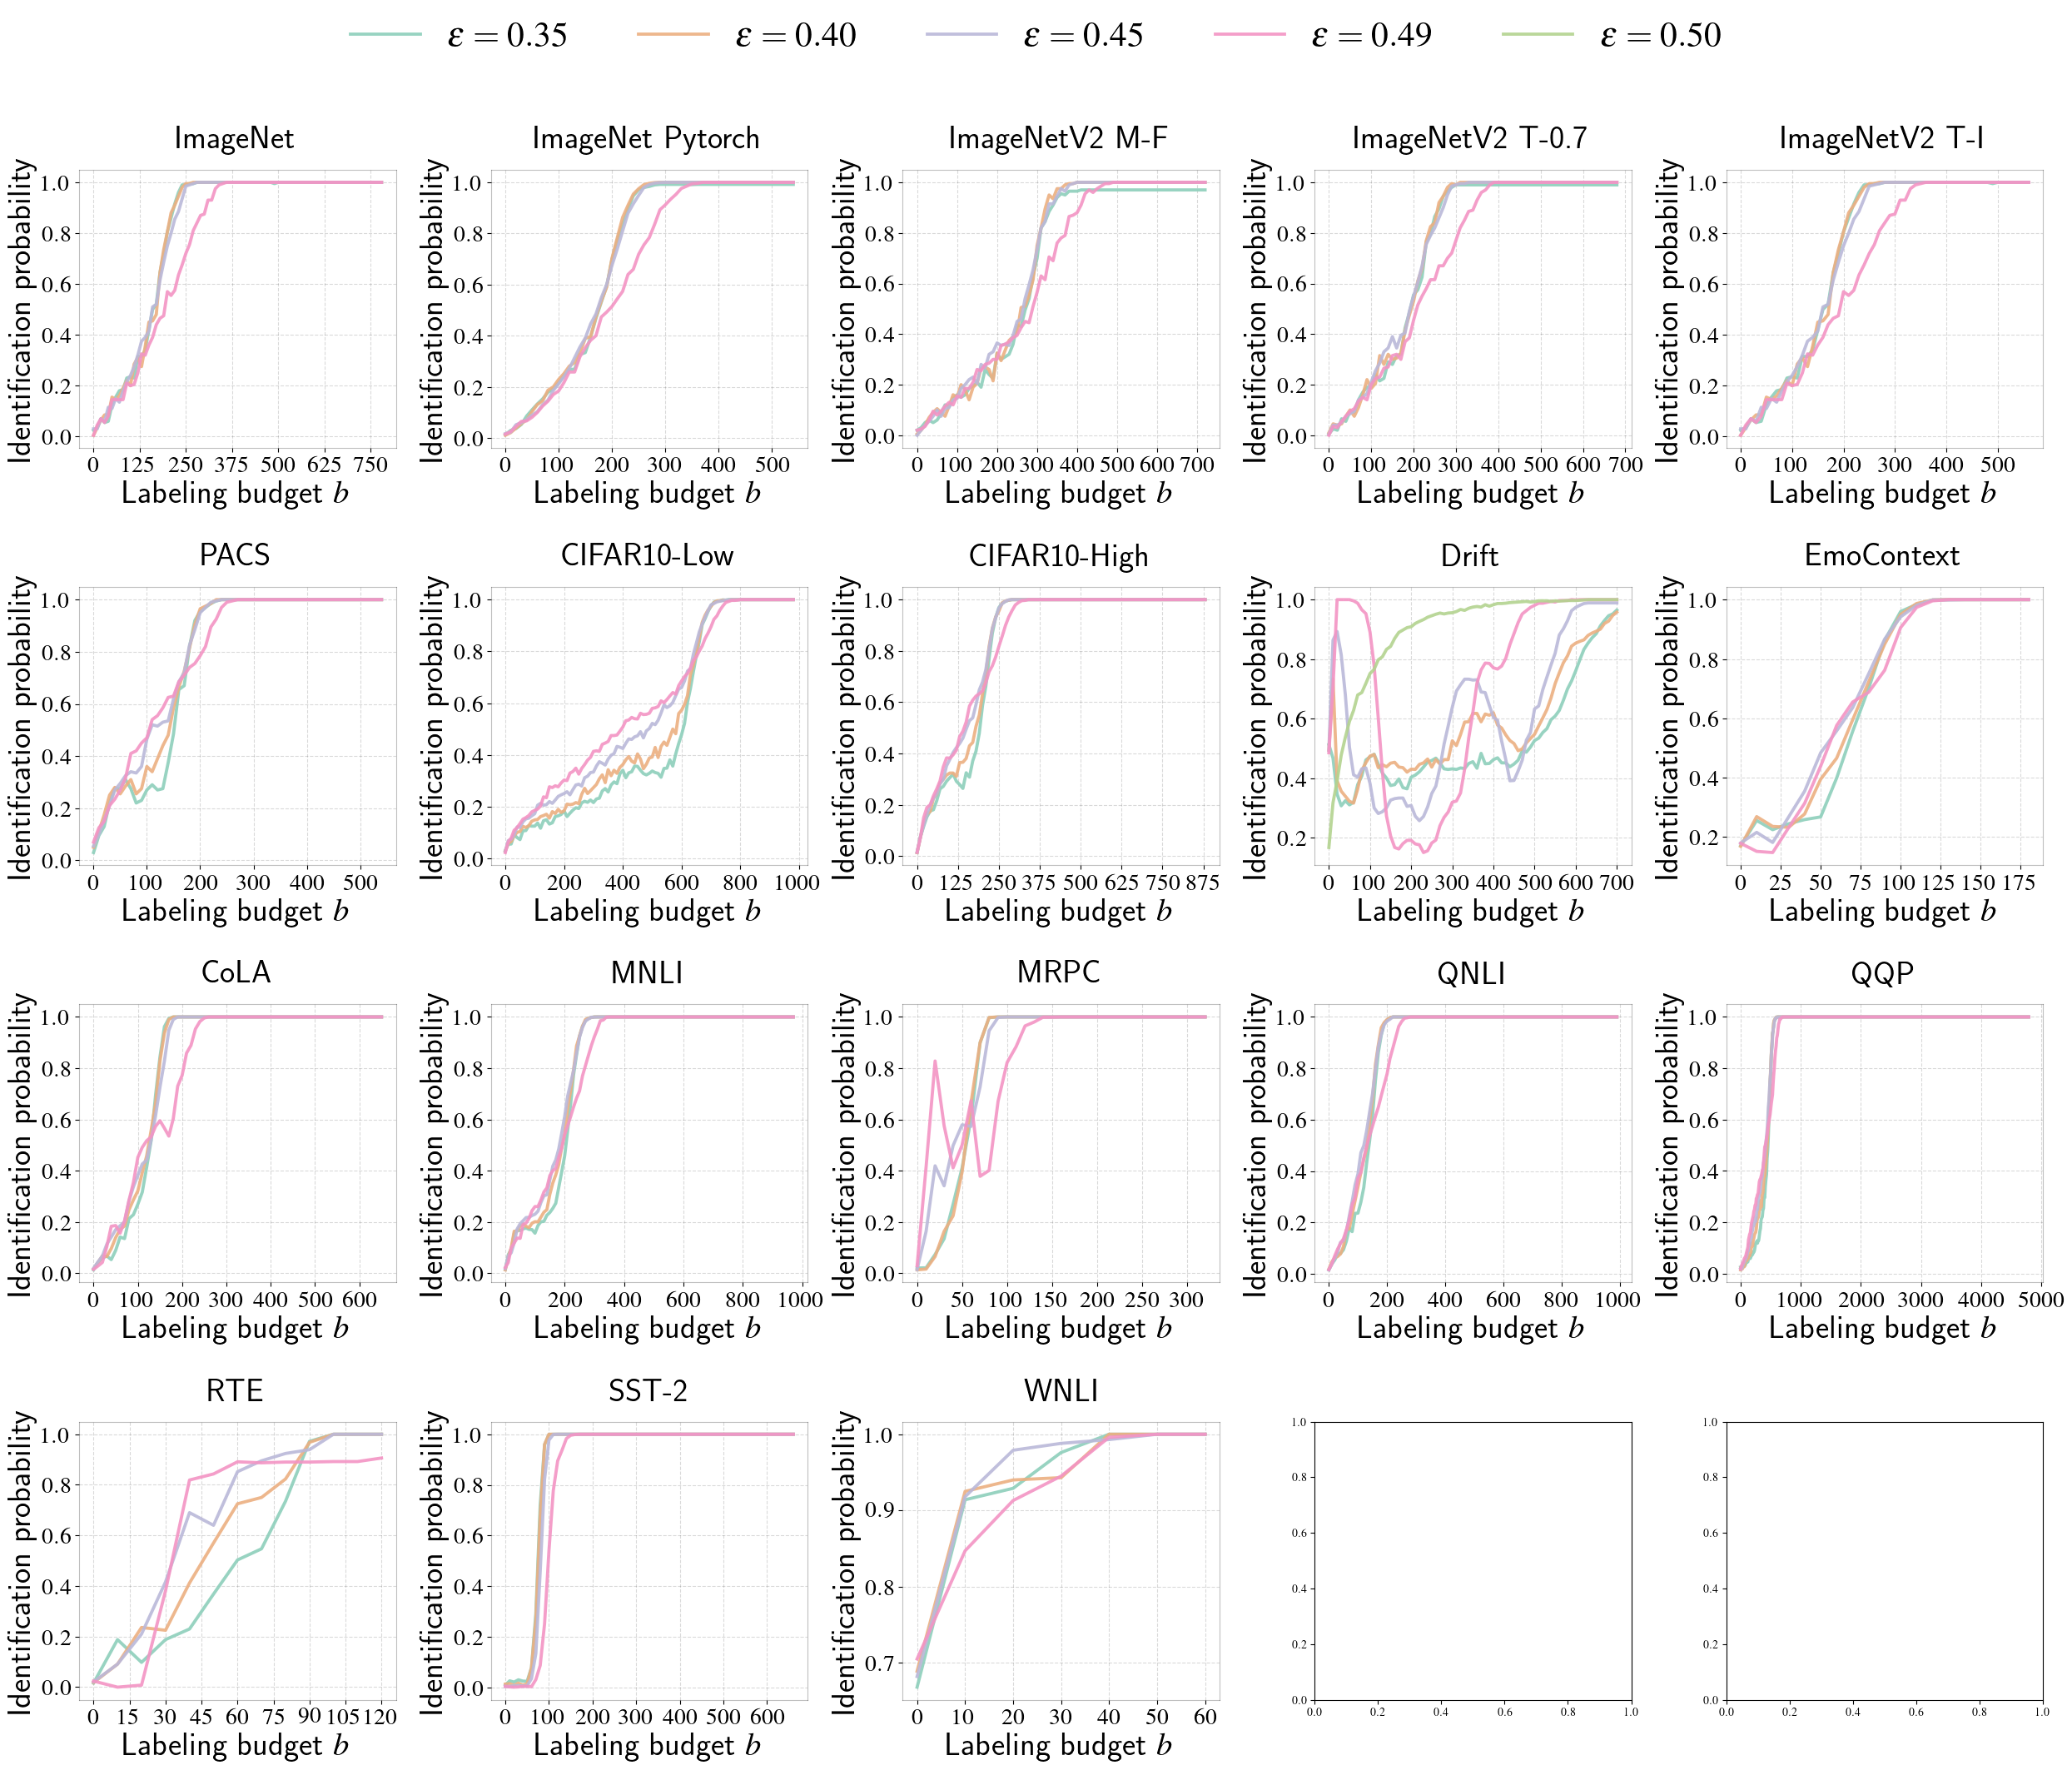

In [162]:
colors = plt.cm.Dark2(np.linspace(0, 1, 8))
epsilon_range = ['0.35', '0.4', '0.45', '0.49', '0.5']
colormapping = {epsilon_range[0]: make_pastel2(colors[0]),
                epsilon_range[1]: make_pastel2(colors[1]),
                epsilon_range[2]: make_pastel2(colors[2]),
                epsilon_range[3]: make_pastel2(colors[3]),
                epsilon_range[4]: make_pastel2(colors[-4])}

labels = {epsilon_range[0]: r'$\epsilon = 0.35$', 
          epsilon_range[1]: r'$\epsilon = 0.40$',
          epsilon_range[2]: r'$\epsilon = 0.45$',
          epsilon_range[3]: r'$\epsilon = 0.49$',
          epsilon_range[4]: r'$\epsilon = 0.50$'}

dataset_name_mapping = {
    'imagenet': 'ImageNet',
    'imagenet_pytorch_models': 'ImageNet Pytorch',
    'imagenet_v2_matched-frequency': 'ImageNetV2 M-F',
    'imagenet_v2_threshold-07': 'ImageNetV2 T-0.7',
    'imagenet_v2_top-images': 'ImageNetV2 T-I',
    'pacs': 'PACS',
    'cifar10_4070': 'CIFAR10-Low',
    'cifar10_5592': 'CIFAR10-High',
    'domain_drift': 'Drift',
    'emotion': 'EmoContext',
    'glue_cola': 'CoLA',
    'glue_mnli': 'MNLI',
    'glue_mrpc': 'MRPC',
    'glue_qnli': 'QNLI',
    'glue_qqp': 'QQP',
    'glue_rte': 'RTE',
    'glue_sst2': 'SST-2',
    'glue_wnli': 'WNLI'
}

dataset_xticks = {
    'imagenet': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'imagenet_pytorch_models': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'imagenet_v2_matched-frequency': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_threshold-07': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_top-images': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'pacs': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'cifar10_4070':  [-250.0, 0.0, 200., 400.0, 600., 800.0, 1000.0],
    'cifar10_5592': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'domain_drift': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'emotion': [-50.0, 0.0, 25.,  50.0, 75., 100.0, 125., 150.0, 175., 200.0],
    'glue_cola': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_mnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_mrpc': [-100.0, 0.0, 50., 100.0, 150., 200.0, 250., 300.0, 350., 400.0],
    'glue_qnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_qqp': [-2000.0, 0.0, 1000., 2000.0, 3000., 4000.0, 5000., 6000.0],
    'glue_rte': [-25.0, 0.0, 15.0, 30., 45.0, 60.0, 75., 90., 105., 120., 135.],
    'glue_sst2': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_wnli': [-20.0, 0.0, 10., 20.0, 30., 40.0, 50., 60.0, 70., 80.0]
}

plot_results_epsilon(nois_epsilon_success_prob, 'Identification probability', 'nois_epsilon_coarse.pdf', size=(25, 21), title_mapping=dataset_name_mapping, freq=10,
             xtick_mapping=dataset_xticks, labels=labels, epsilon_range=epsilon_range, colormapping=colormapping,
             cutoff=second_best_cutoff)

In [205]:
# fine-grained
# plotting
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as mcolors

# Use LaTeX for all text rendering
rc('text', usetex=True)

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

# Enable LaTeX for text rendering (pdflatex)
rc('text', usetex=True)

# Set the font to Times using the appropriate LaTeX package
rcParams['text.latex.preamble'] = r'''
    \usepackage{mathptmx}  % Use Times font for text and math
'''

def make_pastel2(color, weight=0.5):
    color = np.array(mcolors.to_rgba(color))  # Ensure the color is in RGBA format
    white = np.array([1.0, 1.0, 1.0, 1.0])   # White color in RGBA
    pastel_color = color * weight + white * (1 - weight)
    return pastel_color

def plot_results_epsilon_fine(dictionary, y_title, filename, size=(8, 16), title_mapping=None, freq=1,  xtick_mapping=None, cutoff=None, colors=None, 
                         labels=None, folder_epsilon_range=None):

    # Create a 6-column by 3-row figure
    # fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    fig, axes = plt.subplots(4, 5, figsize=size)
        

    # Generate some dummy data
    
    # labels = [r'\textsc{Model Picker}', r'\textsc{random}', r'\textsc{uncertainty}', r'\textsc{margin}', r'\textsc{amc}', r'\textsc{vma}']
    for i, (ax, folder_key) in enumerate(zip(axes.flatten(), title_mapping.keys())):
        folder_title = None
        lines = []
        labels = []
        for key in dictionary.keys():
            if folder_key in key:
                folder = key
                folder_title = title_mapping[folder_key]
            
        print(folder, folder_title)
        index_color = 0
        for method in dictionary[folder].keys():
            # Plot 6 lines with different colors
            try:
                current_eps = str(float(method.split('_')[-1]))
            except Exception as e:
                print(f'{method} cannot get epsilon from it.')
                continue
            
            if current_eps not in folder_epsilon_range[folder_title]:
                continue
 
            color = colors[index_color]
            index_color += 1
            # marker = markermapping[method] 
            # linestyle = linestylemapping[method]
            marker = None
            linestyle = None
            
            x = np.arange(len(dictionary[folder][method]))
            y = dictionary[folder][method]
            if cutoff is not None:
                cutoff_key = folder_key
                if 'imagenet' in folder_key:
                    cutoff_key += '1k'
                if 'emotion' in folder_key:
                    cutoff_key = 'emotion_detection'
                x = np.arange(cutoff[cutoff_key])
                y = y[:cutoff[cutoff_key]]
                
            x = x[::freq]
            y = y[::freq]

            if xtick_mapping is not None:
                ax.set_xticks(xtick_mapping[folder_key])
            
            # adjust ticks size
            # Adjust font size of ticks
            ax.tick_params(axis='x', labelsize=20)  # x-axis
            ax.tick_params(axis='y', labelsize=20)  # y-axis
            
            # less opaque plotbox
            for spine in ax.spines.values():
                spine.set_edgecolor('black')  # Set the color of the edge (spine)
                spine.set_alpha(0.25) 
            ax.grid(True, alpha=0.15, color='black', linestyle='--')         
               
            label = rf'$\epsilon = {current_eps}$'
            labels.append(label)
            line, = ax.plot(x, y, color=color, label=label, alpha=0.9, linewidth=2.75) #@, marker=marker, markersize=2, linestyle=linestyle)
            # Store the lines to use in the legend
            
            lines.append(line)
            
        # ax.set_title(folder, fontsize=28, y=1.05)
        ax.set_title(folder_title, fontsize=28, y=1.1)
        ax.set_ylabel(y_title, fontsize=28)
        ax.set_xlabel('Labeling budget $b$', fontsize=28)

        # Create a shared legend at the bottom of the figure
        leg = ax.legend(lines, labels, fontsize=20)
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('white') 
        leg.get_frame().set_alpha(1.0)
        # leg = fig.legend(labels.values(), loc='upper center', ncol=3, fontsize=30, bbox_to_anchor=(0.5, 1.07),)

    # Use tight_layout to ensure subplots fit in the figure area
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # Now adjust the vertical space manually with hspace
    plt.subplots_adjust(hspace=0.6, wspace=0.4)
    
    # plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # Leave 7% space at the top
    
    plt.savefig(filename,bbox_inches='tight')
    # save svg
    plt.savefig(filename.replace('.pdf', '.svg'),bbox_inches='tight', transparent=False)
    # Display the plot
    plt.show()

gridsearch_imagenet_v2_threshold-07_vote_finegrained ImageNet
Random cannot get epsilon from it.
gridsearch_imagenet_pytorch_models_vote_finegrained ImageNet Pytorch
Random cannot get epsilon from it.
gridsearch_imagenet_v2_matched-frequency_vote_finegrained ImageNetV2 M-F
Random cannot get epsilon from it.
gridsearch_imagenet_v2_threshold-07_vote_finegrained ImageNetV2 T-0.7
Random cannot get epsilon from it.
gridsearch_imagenet_v2_top-images_vote_finegrained ImageNetV2 T-I
Random cannot get epsilon from it.
gridsearch_pacs_vote_finegrained PACS
gridsearch_cifar10_4070_vote_finegrained CIFAR10-Low
gridsearch_cifar10_5592_vote_finegrained CIFAR10-High
gridsearch_domain_drift_vote_finegrained_2024-10-14_09-51-24 Drift
gridsearch_emotion_vote_finegrained EmoContext
gridsearch_glue_cola_vote_finegrained CoLA
gridsearch_glue_mnli_vote_finegrained MNLI
gridsearch_glue_mrpc_vote_finegrained MRPC
gridsearch_glue_qnli_vote_finegrained QNLI
gridsearch_glue_qqp_vote_finegrained QQP
gridsearch_gl

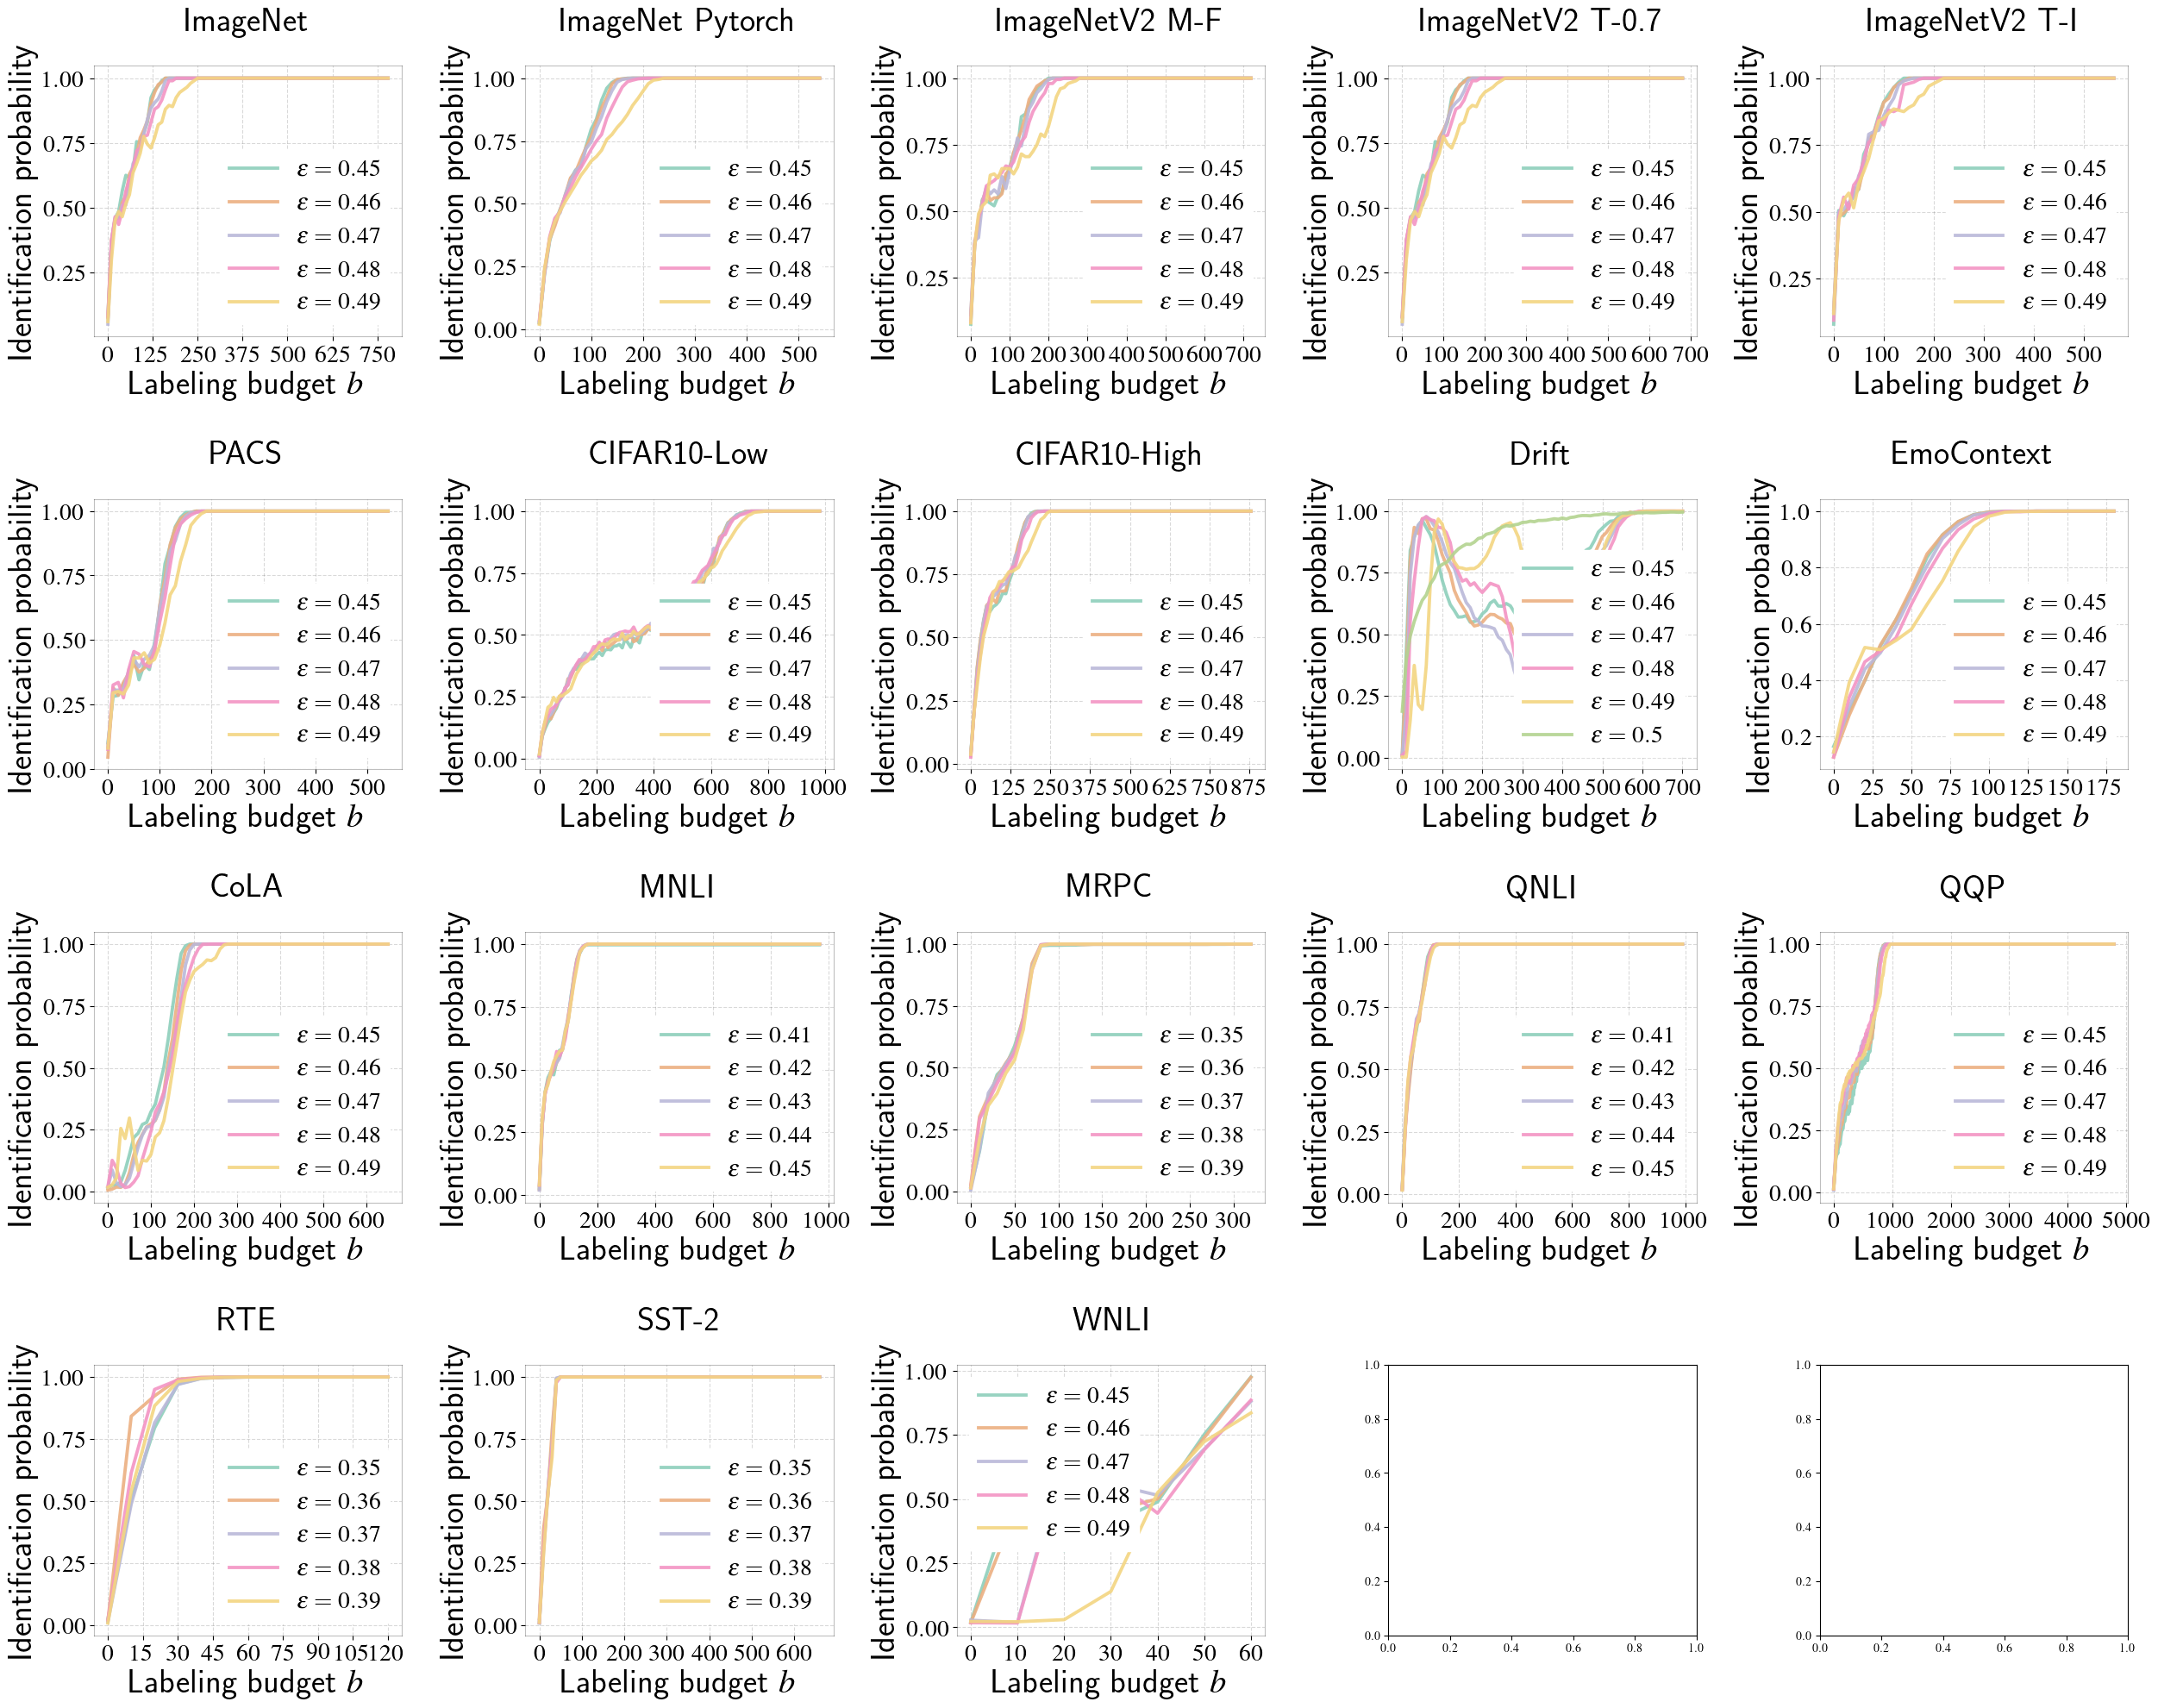

In [206]:
colors = plt.cm.Dark2(np.linspace(0, 1, 8))
colors = [make_pastel2(colors[0]),
          make_pastel2(colors[1]),
          make_pastel2(colors[2]),
          make_pastel2(colors[3]),
          make_pastel2(colors[-3]),
          make_pastel2(colors[-4])]

dataset_name_mapping = {
    'imagenet': 'ImageNet',
    'imagenet_pytorch_models': 'ImageNet Pytorch',
    'imagenet_v2_matched-frequency': 'ImageNetV2 M-F',
    'imagenet_v2_threshold-07': 'ImageNetV2 T-0.7',
    'imagenet_v2_top-images': 'ImageNetV2 T-I',
    'pacs': 'PACS',
    'cifar10_4070': 'CIFAR10-Low',
    'cifar10_5592': 'CIFAR10-High',
    'domain_drift': 'Drift',
    'emotion': 'EmoContext',
    'glue_cola': 'CoLA',
    'glue_mnli': 'MNLI',
    'glue_mrpc': 'MRPC',
    'glue_qnli': 'QNLI',
    'glue_qqp': 'QQP',
    'glue_rte': 'RTE',
    'glue_sst2': 'SST-2',
    'glue_wnli': 'WNLI'
}

dataset_xticks = {
    'imagenet': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'imagenet_pytorch_models': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'imagenet_v2_matched-frequency': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_threshold-07': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_top-images': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'pacs': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'cifar10_4070':  [-250.0, 0.0, 200., 400.0, 600., 800.0, 1000.0],
    'cifar10_5592': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'domain_drift': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'emotion': [-50.0, 0.0, 25.,  50.0, 75., 100.0, 125., 150.0, 175., 200.0],
    'glue_cola': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_mnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_mrpc': [-100.0, 0.0, 50., 100.0, 150., 200.0, 250., 300.0, 350., 400.0],
    'glue_qnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_qqp': [-2000.0, 0.0, 1000., 2000.0, 3000., 4000.0, 5000., 6000.0],
    'glue_rte': [-25.0, 0.0, 15.0, 30., 45.0, 60.0, 75., 90., 105., 120., 135.],
    'glue_sst2': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_wnli': [-20.0, 0.0, 10., 20.0, 30., 40.0, 50., 60.0, 70., 80.0]
}

folder_epsilon_range = { 
 'ImageNet': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'ImageNet Pytorch': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'ImageNetV2 M-F': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'ImageNetV2 T-0.7': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'ImageNetV2 T-I': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'PACS': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'CIFAR10-Low': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'CIFAR10-High': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'Drift': ['0.45', '0.46', '0.47', '0.48', '0.49', '0.5'],
 'EmoContext': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'CoLA': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'MNLI': ['0.41', '0.42', '0.43', '0.44', '0.45'],
 'MRPC': ['0.35', '0.36', '0.37', '0.38', '0.39'],
 'QNLI': ['0.41', '0.42', '0.43', '0.44', '0.45'],
 'QQP': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'RTE': ['0.35', '0.36', '0.37', '0.38', '0.39'],
 'SST-2': ['0.35', '0.36', '0.37', '0.38', '0.39'],
 'WNLI'   : ['0.45', '0.46', '0.47', '0.48', '0.49']
}

plot_results_epsilon_fine(gt_epsilon_success_prob, 'Identification probability', 'gt_epsilon_fine.pdf', size=(25, 21), title_mapping=dataset_name_mapping, freq=10,
             xtick_mapping=dataset_xticks, labels=labels, colors=colors,
             cutoff=second_best_cutoff,
             folder_epsilon_range=folder_epsilon_range)

gridsearch_imagenet_v2_top-images_vote_finegrained_2024-09-24_10-54-41 ImageNet
Random cannot get epsilon from it.
gridsearch_imagenet_pytorch_models_vote_finegrained_2024-09-25_11-56-18 ImageNet Pytorch
Random cannot get epsilon from it.
gridsearch_imagenet_v2_matched-frequency_vote_finegrained_2024-09-24_14-06-22 ImageNetV2 M-F
Random cannot get epsilon from it.
gridsearch_imagenet_v2_threshold-07_vote_finegrained_2024-09-24_12-10-18 ImageNetV2 T-0.7
Random cannot get epsilon from it.
gridsearch_imagenet_v2_top-images_vote_finegrained_2024-09-24_10-54-41 ImageNetV2 T-I
Random cannot get epsilon from it.
gridsearch_pacs_vote_finegrained_2024-09-24_03-33-11 PACS
gridsearch_cifar10_4070_vote_finegrained_2024-09-24_04-36-53 CIFAR10-Low
gridsearch_cifar10_5592_vote_finegrained_2024-09-24_04-26-32 CIFAR10-High
gridsearch_domain_drift_vote_finegrained Drift
gridsearch_emotion_vote_finegrained_2024-09-24_03-33-03 EmoContext
gridsearch_glue_cola_vote_finegrained_2024-09-24_03-46-35 CoLA
grids

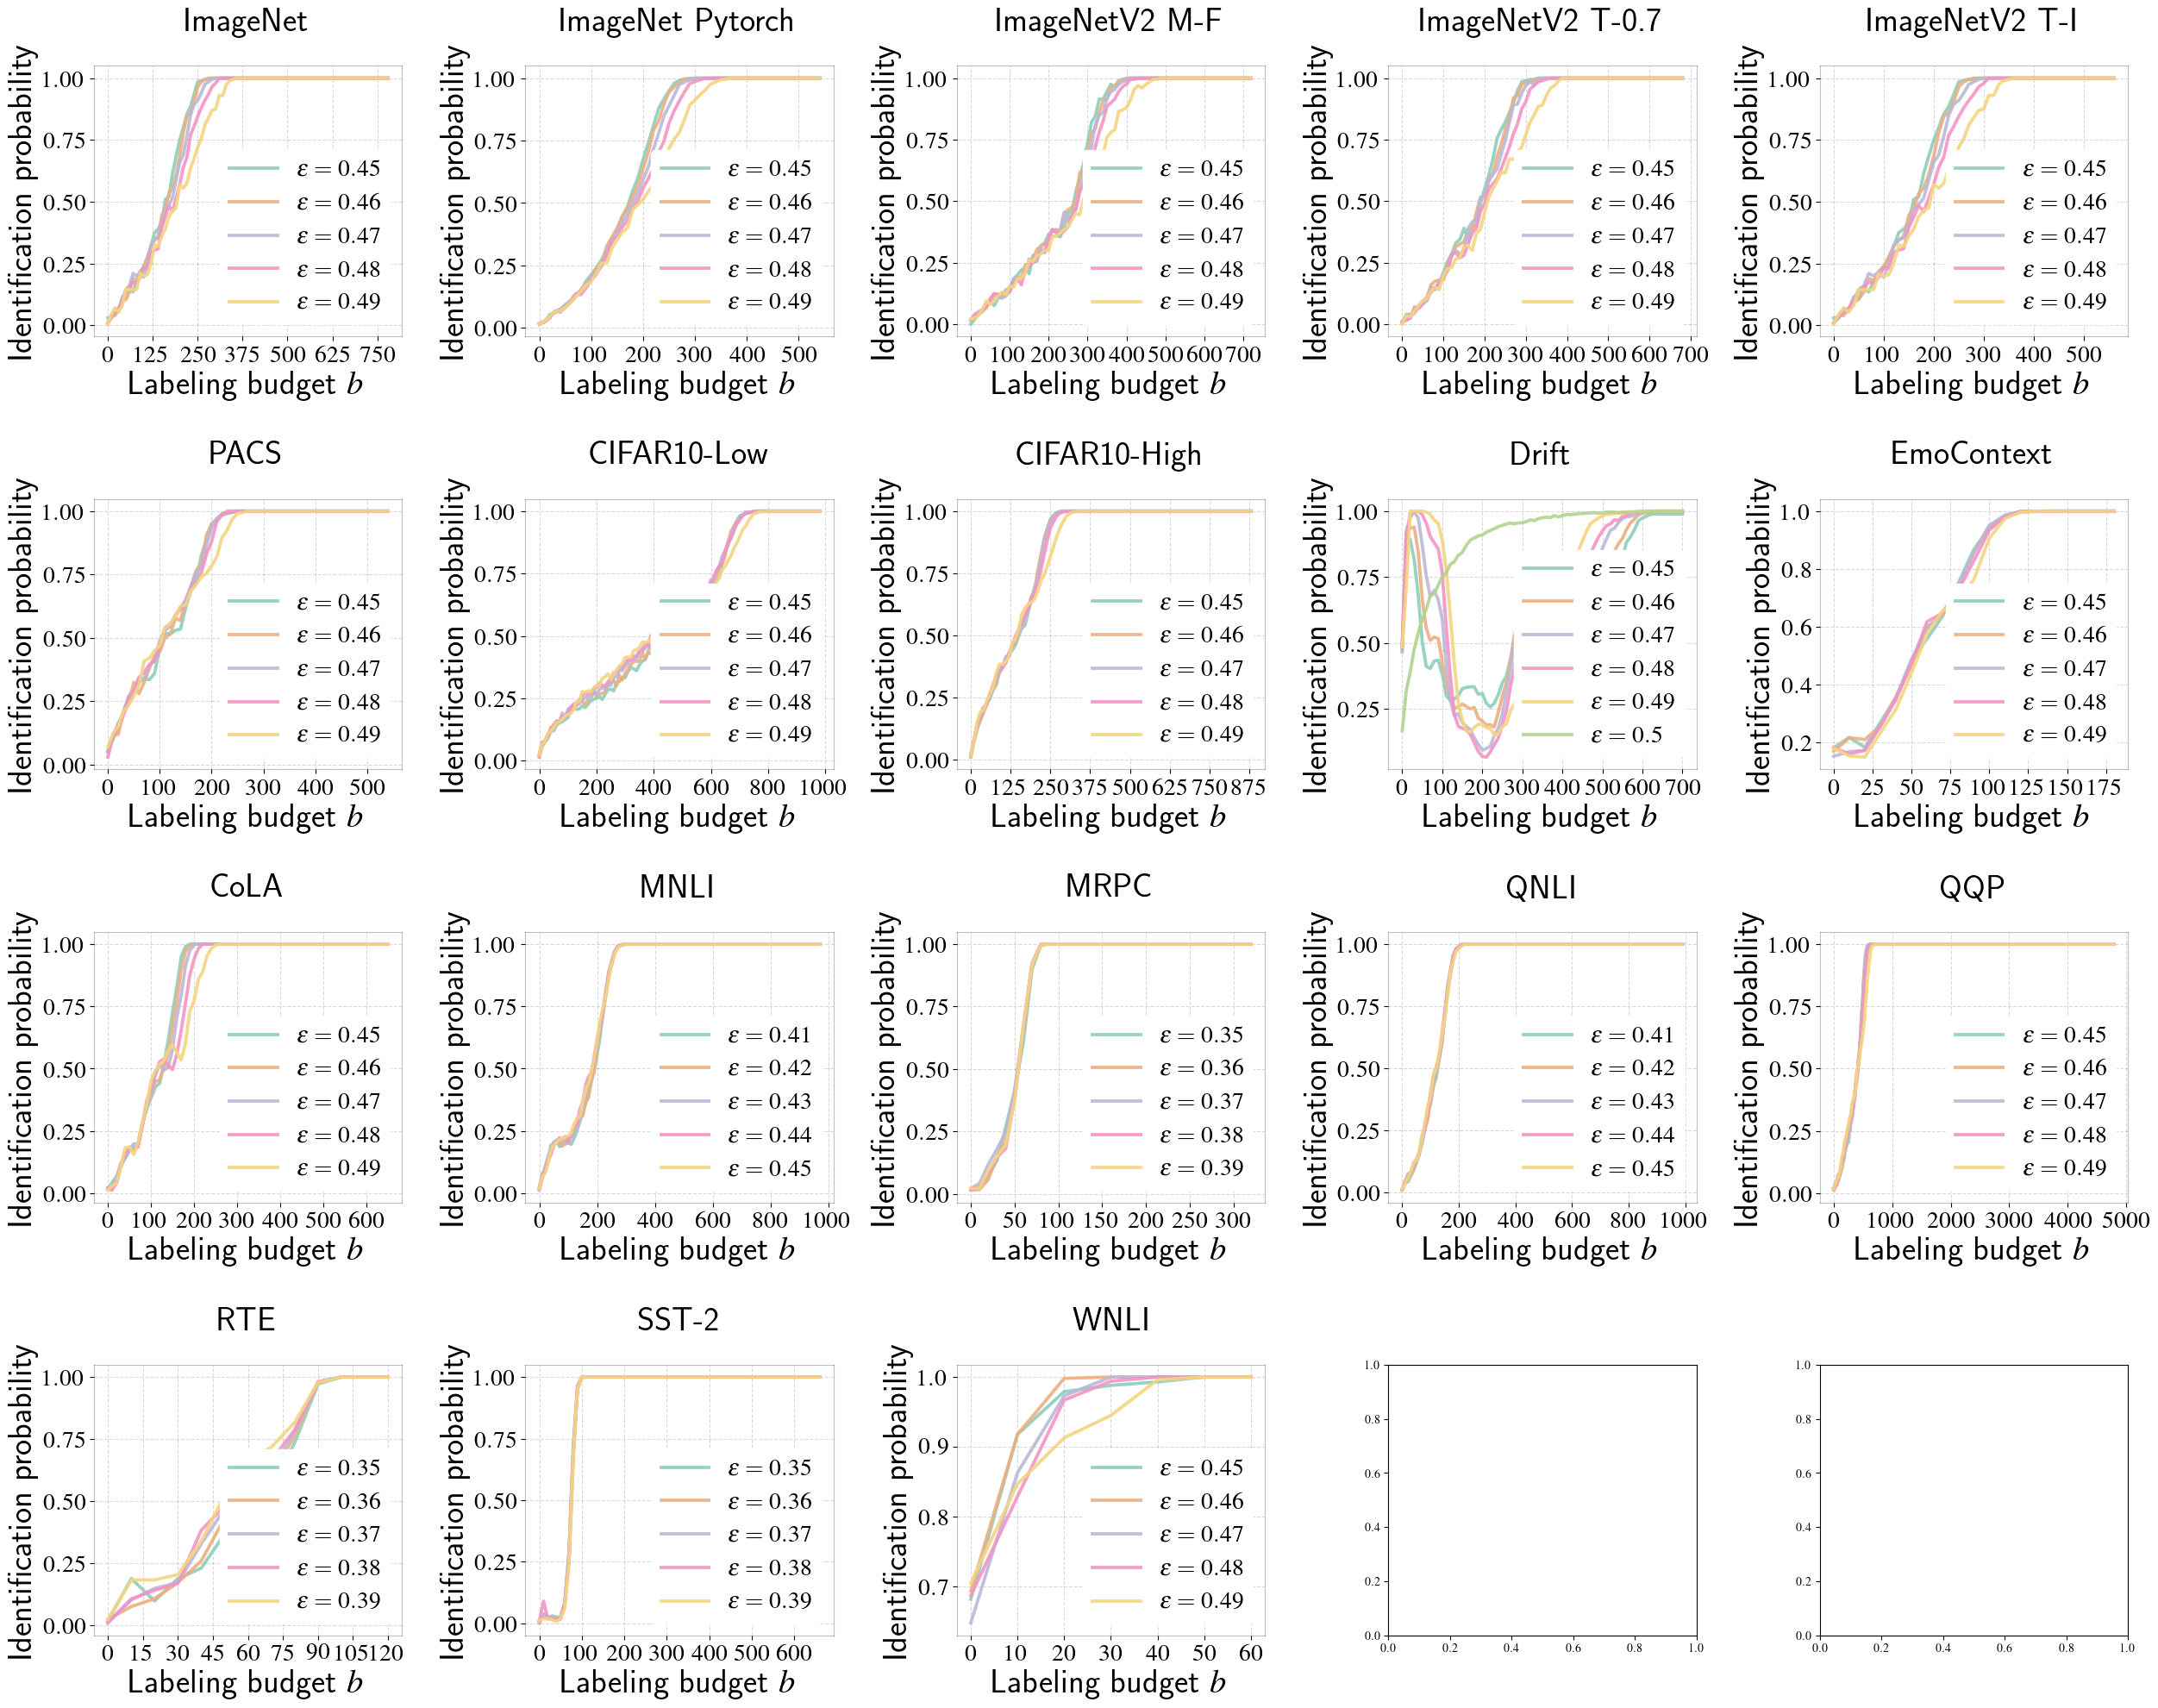

In [207]:
colors = plt.cm.Dark2(np.linspace(0, 1, 8))
colors = [make_pastel2(colors[0]),
          make_pastel2(colors[1]),
          make_pastel2(colors[2]),
          make_pastel2(colors[3]),
          make_pastel2(colors[-3]),
          make_pastel2(colors[-4])]

dataset_name_mapping = {
    'imagenet': 'ImageNet',
    'imagenet_pytorch_models': 'ImageNet Pytorch',
    'imagenet_v2_matched-frequency': 'ImageNetV2 M-F',
    'imagenet_v2_threshold-07': 'ImageNetV2 T-0.7',
    'imagenet_v2_top-images': 'ImageNetV2 T-I',
    'pacs': 'PACS',
    'cifar10_4070': 'CIFAR10-Low',
    'cifar10_5592': 'CIFAR10-High',
    'domain_drift': 'Drift',
    'emotion': 'EmoContext',
    'glue_cola': 'CoLA',
    'glue_mnli': 'MNLI',
    'glue_mrpc': 'MRPC',
    'glue_qnli': 'QNLI',
    'glue_qqp': 'QQP',
    'glue_rte': 'RTE',
    'glue_sst2': 'SST-2',
    'glue_wnli': 'WNLI'
}

dataset_xticks = {
    'imagenet': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'imagenet_pytorch_models': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'imagenet_v2_matched-frequency': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_threshold-07': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'imagenet_v2_top-images': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'pacs': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0],
    'cifar10_4070':  [-250.0, 0.0, 200., 400.0, 600., 800.0, 1000.0],
    'cifar10_5592': [-250.0, 0.0, 125., 250.0, 375., 500.0, 625., 750.0, 875., 1000.0],
    'domain_drift': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'emotion': [-50.0, 0.0, 25.,  50.0, 75., 100.0, 125., 150.0, 175., 200.0],
    'glue_cola': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_mnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_mrpc': [-100.0, 0.0, 50., 100.0, 150., 200.0, 250., 300.0, 350., 400.0],
    'glue_qnli': [-500.0, 0.0, 200., 400.0, 600., 800.0, 1000.0, 1500.0],
    'glue_qqp': [-2000.0, 0.0, 1000., 2000.0, 3000., 4000.0, 5000., 6000.0],
    'glue_rte': [-25.0, 0.0, 15.0, 30., 45.0, 60.0, 75., 90., 105., 120., 135.],
    'glue_sst2': [-200.0, 0.0, 100., 200.0, 300., 400.0, 500., 600.0, 700., 800.0],
    'glue_wnli': [-20.0, 0.0, 10., 20.0, 30., 40.0, 50., 60.0, 70., 80.0]
}

folder_epsilon_range = { 
 'ImageNet': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'ImageNet Pytorch': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'ImageNetV2 M-F': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'ImageNetV2 T-0.7': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'ImageNetV2 T-I': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'PACS': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'CIFAR10-Low': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'CIFAR10-High': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'Drift': ['0.45', '0.46', '0.47', '0.48', '0.49', '0.5'],
 'EmoContext': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'CoLA': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'MNLI': ['0.41', '0.42', '0.43', '0.44', '0.45'],
 'MRPC': ['0.35', '0.36', '0.37', '0.38', '0.39'],
 'QNLI': ['0.41', '0.42', '0.43', '0.44', '0.45'],
 'QQP': ['0.45', '0.46', '0.47', '0.48', '0.49'],
 'RTE': ['0.35', '0.36', '0.37', '0.38', '0.39'],
 'SST-2': ['0.35', '0.36', '0.37', '0.38', '0.39'],
 'WNLI'   : ['0.45', '0.46', '0.47', '0.48', '0.49']
}

plot_results_epsilon_fine(nois_epsilon_success_prob, 'Identification probability', 'nois_epsilon_fine.pdf', size=(25, 21), title_mapping=dataset_name_mapping, freq=10,
             xtick_mapping=dataset_xticks, labels=labels, colors=colors,
             cutoff=second_best_cutoff,
             folder_epsilon_range=folder_epsilon_range)

In [111]:
# collect noisy to gt
def get_epsilon_results_noisy_to_gt(path):
    epsilon_success_prob = {}

    for folder in os.listdir(path):
        epsilon_success_prob[folder] = {}
        folder_path = os.path.join(path, folder)
        
        if folder.startswith('OLD'):
            continue
        
        res_file = 'experiment_result.json'
        
        with open(os.path.join(folder_path, res_file), 'r') as f:
            data = json.load(f)
        res = ExperimentResult.from_json(data)            
        
        print(folder)
        res.global_best_accuracy = np.array(res.global_best_accuracy)
        for model_selection_algorithm in tqdm(res.iteration_results.keys()):
            # create numpy arrays from saved lists
            res.iteration_results[model_selection_algorithm]["bestModelSelectedT"] = np.array(res.iteration_results[model_selection_algorithm]["bestModelSelectedT"])
            res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"] = np.array(res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"])
            
            # get success probability
            epsilon_success_prob[folder][model_selection_algorithm] = np.mean(res.iteration_results[model_selection_algorithm]["bestModelSelectedT"], axis=0).tolist()
    return epsilon_success_prob

noisy_to_gt_rte_wnli = get_epsilon_results(path='path')

gridsearch_glue_wnli_vote_finegrainedgt60


100%|██████████| 15/15 [00:00<00:00, 239.08it/s]


gridsearch_glue_rte_vote_finegrainedgt30


100%|██████████| 15/15 [00:00<00:00, 62.42it/s]


gridsearch_glue_rte_vote_finegrainedgt40


100%|██████████| 15/15 [00:00<00:00, 64.43it/s]


gridsearch_glue_rte_vote_finegrainedgt10


100%|██████████| 15/15 [00:00<00:00, 57.81it/s]


gridsearch_glue_rte_vote_finegrainedgt70


100%|██████████| 15/15 [00:00<00:00, 43.59it/s]


gridsearch_glue_wnli_vote_finegrainedgt10


100%|██████████| 15/15 [00:00<00:00, 212.96it/s]


gridsearch_glue_wnli_vote_finegrainedgt40


100%|██████████| 15/15 [00:00<00:00, 200.87it/s]


gridsearch_glue_rte_vote_finegrainedgt90


100%|██████████| 15/15 [00:00<00:00, 61.49it/s]


gridsearch_glue_wnli_vote_finegrainedgt65


100%|██████████| 15/15 [00:00<00:00, 204.70it/s]


gridsearch_glue_rte_vote_finegrainedgt20


100%|██████████| 15/15 [00:00<00:00, 59.23it/s]


gridsearch_glue_wnli_vote_finegrainedgt20


100%|██████████| 15/15 [00:00<00:00, 198.10it/s]


gridsearch_glue_rte_vote_finegrainedgt250


100%|██████████| 15/15 [00:00<00:00, 48.35it/s]


gridsearch_glue_wnli_vote_finegrainedgt50


100%|██████████| 15/15 [00:00<00:00, 215.40it/s]


gridsearch_glue_rte_vote_finegrainedgt50


100%|██████████| 15/15 [00:00<00:00, 45.78it/s]


gridsearch_glue_rte_vote_finegrainedgt100


100%|██████████| 15/15 [00:00<00:00, 58.82it/s]


gridsearch_glue_rte_vote_finegrainedgt0


100%|██████████| 15/15 [00:00<00:00, 58.88it/s]


gridsearch_glue_rte_vote_finegrainedgt80


100%|██████████| 15/15 [00:00<00:00, 55.68it/s]


gridsearch_glue_rte_vote_finegrainedgt60


100%|██████████| 15/15 [00:00<00:00, 50.35it/s]


gridsearch_glue_wnli_vote_finegrainedgt0


100%|██████████| 15/15 [00:00<00:00, 197.40it/s]


gridsearch_glue_wnli_vote_finegrainedgt30


100%|██████████| 15/15 [00:00<00:00, 208.72it/s]


In [176]:
# plotting
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as mcolors

# Use LaTeX for all text rendering
rc('text', usetex=True)

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

# Enable LaTeX for text rendering (pdflatex)
rc('text', usetex=True)

# Set the font to Times using the appropriate LaTeX package
rcParams['text.latex.preamble'] = r'''
    \usepackage{mathptmx}  % Use Times font for text and math
'''

def make_pastel2(color, weight=0.5):
    color = np.array(mcolors.to_rgba(color))  # Ensure the color is in RGBA format
    white = np.array([1.0, 1.0, 1.0, 1.0])   # White color in RGBA
    pastel_color = color * weight + white * (1 - weight)
    return pastel_color

def plot_noisy_to_gt(dictionary, y_title, filename, size=(8, 16), freq=1,  xtick=None, cutoff=None, colors=None, epsilon_range=None, labels=None,
                     grid_shape=None, title=None):

    # Create a 6-column by 3-row figure
    # fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=size)
        

    # Generate some dummy data
    lines = []
    # labels = [r'\textsc{Model Picker}', r'\textsc{random}', r'\textsc{uncertainty}', r'\textsc{margin}', r'\textsc{amc}', r'\textsc{vma}']
    my_list = list(dictionary.keys())
    sorted_list = sorted(my_list, key=lambda x: (x.split('finegrainedgt')[0], int(x.split('finegrainedgt')[1])))
    filtered_list = [x for x in sorted_list if title in x]


    for i, (ax, folder_key) in enumerate(zip(axes.flatten(), filtered_list)):
        color_index = 0       
        for method in dictionary[folder_key].keys():
            # Plot 6 lines with different colors
            try:
                current_eps = str(float(method.split('_')[-1]))
            except Exception as e:
                print(f'{method} cannot get epsilon from it.')
                continue
            
            if current_eps not in epsilon_range:
                continue
 
            color = colors[color_index] 
            color_index += 1
            # marker = markermapping[method] 
            # linestyle = linestylemapping[method]
            marker = None
            linestyle = None            
            
            x = np.arange(len(dictionary[folder_key][method]))
            y = dictionary[folder_key][method]
        
            x = np.arange(cutoff)
            y = y[:cutoff]
                
            x = x[::freq]
            y = y[::freq]

            # if xtick_mapping is not None:
            ax.set_xticks(xtick)
            
            # adjust ticks size
            # Adjust font size of ticks
            ax.tick_params(axis='x', labelsize=14)  # x-axis
            ax.tick_params(axis='y', labelsize=14)  # y-axis
            
            # less opaque plotbox
            for spine in ax.spines.values():
                spine.set_edgecolor('black')  # Set the color of the edge (spine)
                spine.set_alpha(0.25) 
            ax.grid(True, alpha=0.15, color='black', linestyle='--')         
               
            label = labels[current_eps]
            line, = ax.plot(x, y, color=color, label=label, alpha=0.9, linewidth=2.75) #@, marker=marker, markersize=2, linestyle=linestyle)
            # Store the lines to use in the legend
            if i == 0:
                lines.append(line)
            
        # ax.set_title(folder, fontsize=28, y=1.05)
        titl = title.upper() + ' with ' + folder_key.split('finegrainedgt')[1] + ' oracle labels'
        ax.set_title(titl, fontsize=22, y=1.1)
        ax.set_ylabel(y_title, fontsize=22)
        ax.set_xlabel('Labeling budget $b$', fontsize=22)

    # Create a shared legend at the bottom of the figure
    leg = fig.legend(lines, labels.values(), loc='upper center', ncol=5, fontsize=24, bbox_to_anchor=(0.5, 1.1),)
    # leg = fig.legend(labels.values(), loc='upper center', ncol=3, fontsize=30, bbox_to_anchor=(0.5, 1.07),)

    # leg.legendHandles[0].set_color(make_pastel2(red_color, weight=0.8))  # Color for 'Line 1'
    # leg.legendHandles[1].set_color(colormapping['Random']) 
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('white')


    # Use tight_layout to ensure subplots fit in the figure area
    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # Now adjust the vertical space manually with hspace
    plt.subplots_adjust(hspace=0.7, wspace=0.5)
    
    # plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # Leave 7% space at the top
    
    plt.savefig(filename,bbox_inches='tight')
    # save svg
    plt.savefig(filename.replace('.pdf', '.svg'),bbox_inches='tight')
    # Display the plot
    plt.show()

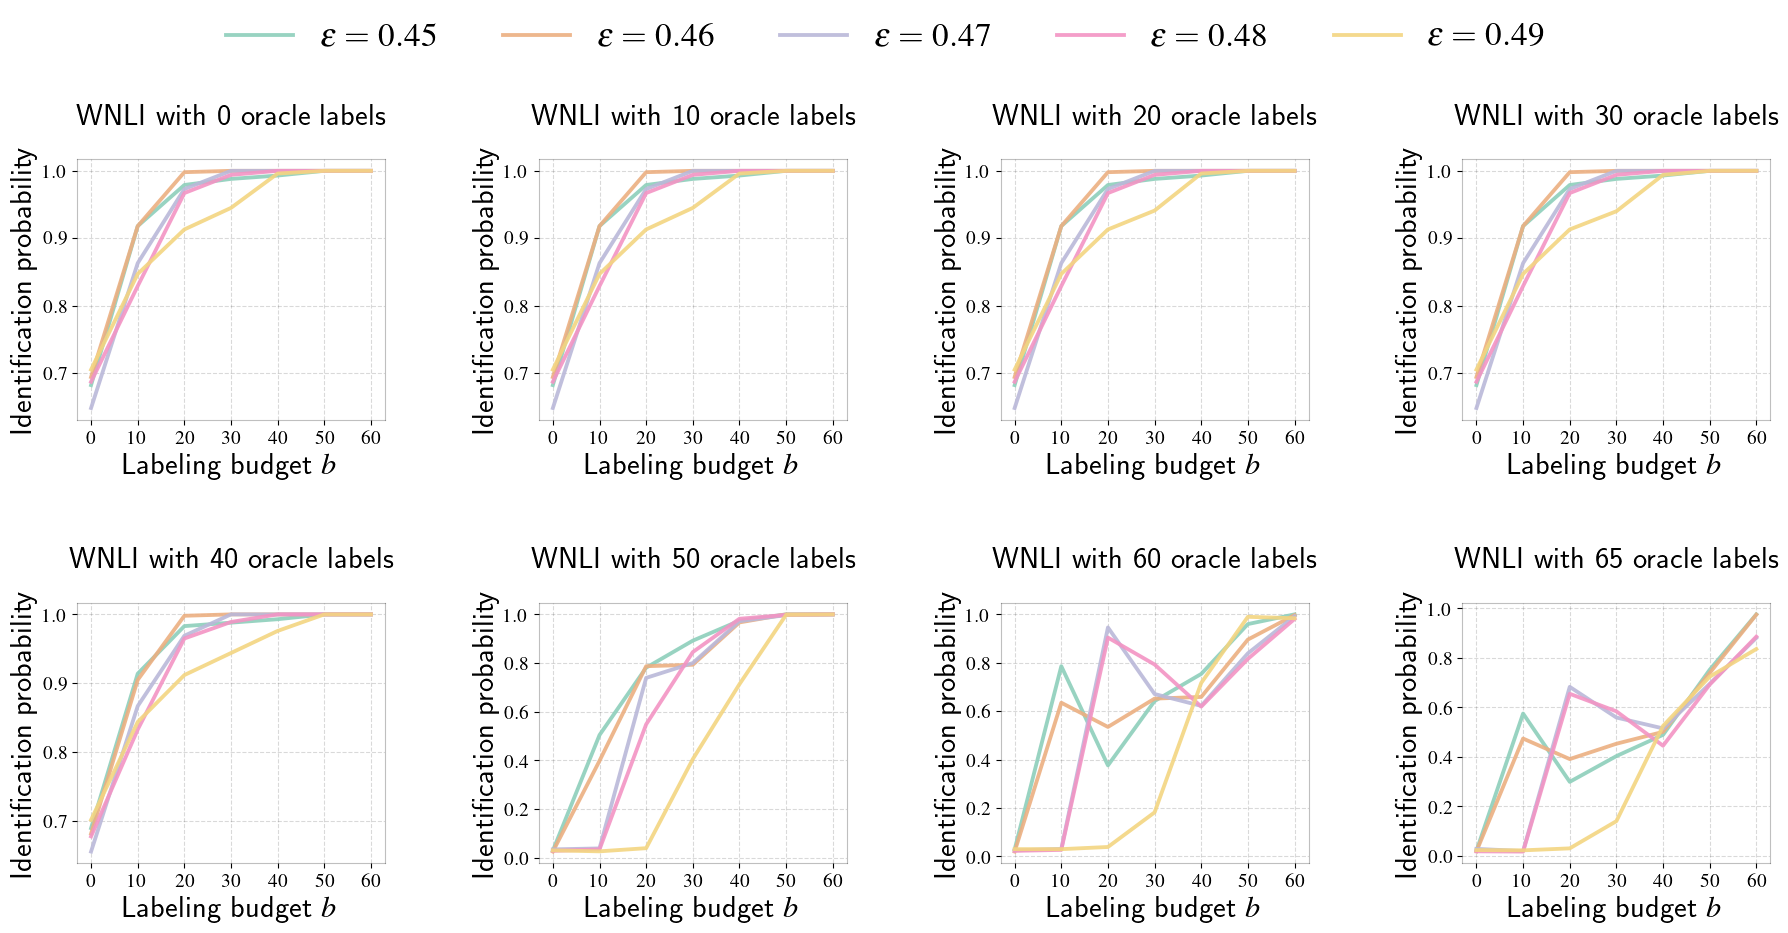

In [181]:
colors = plt.cm.Dark2(np.linspace(0, 1, 8))
colors = [make_pastel2(colors[0]),
          make_pastel2(colors[1]),
          make_pastel2(colors[2]),
          make_pastel2(colors[3]),
          make_pastel2(colors[-3]),
          make_pastel2(colors[-4])]

xtick = [-20.0, 0.0, 10., 20.0, 30., 40.0, 50., 60.0, 70., 80.0]

epsilon_range = ['0.45', '0.46', '0.47', '0.48', '0.49']

cutoff = 64

title = 'wnli'

labels = {epsilon_range[0]: r'$\epsilon = 0.45$', 
          epsilon_range[1]: r'$\epsilon = 0.46$',
          epsilon_range[2]: r'$\epsilon = 0.47$',
          epsilon_range[3]: r'$\epsilon = 0.48$',
          epsilon_range[4]: r'$\epsilon = 0.49$'}

plot_noisy_to_gt(noisy_to_gt_rte_wnli, 'Identification probability', 'noisy_to_gt_wnli.pdf', size=(18, 9), title=title, freq=10,
             xtick=xtick, labels=labels, colors=colors,
             cutoff=cutoff,
             epsilon_range=epsilon_range,
             grid_shape=(2, 4),
             )

gridsearch_glue_rte_vote_finegrainedgt175


100%|██████████| 15/15 [00:00<00:00, 64.86it/s]


gridsearch_glue_rte_vote_finegrainedgt10


100%|██████████| 15/15 [00:00<00:00, 48.14it/s]


gridsearch_glue_rte_vote_finegrainedgt75


100%|██████████| 15/15 [00:00<00:00, 62.24it/s]


gridsearch_glue_rte_vote_finegrainedgt225


100%|██████████| 15/15 [00:00<00:00, 59.36it/s]


gridsearch_glue_rte_vote_finegrainedgt200


100%|██████████| 15/15 [00:00<00:00, 49.89it/s]


gridsearch_glue_rte_vote_finegrainedgt150


100%|██████████| 15/15 [00:00<00:00, 60.11it/s]


gridsearch_glue_rte_vote_finegrainedgt25


100%|██████████| 15/15 [00:00<00:00, 59.72it/s]


gridsearch_glue_rte_vote_finegrainedgt250


100%|██████████| 15/15 [00:00<00:00, 50.62it/s]


gridsearch_glue_rte_vote_finegrainedgt50


100%|██████████| 15/15 [00:00<00:00, 57.18it/s]


gridsearch_glue_rte_vote_finegrainedgt100


100%|██████████| 15/15 [00:00<00:00, 52.41it/s]


gridsearch_glue_rte_vote_finegrainedgt125


100%|██████████| 15/15 [00:00<00:00, 61.91it/s]


gridsearch_glue_rte_vote_finegrainedgt0


100%|██████████| 15/15 [00:00<00:00, 63.22it/s]


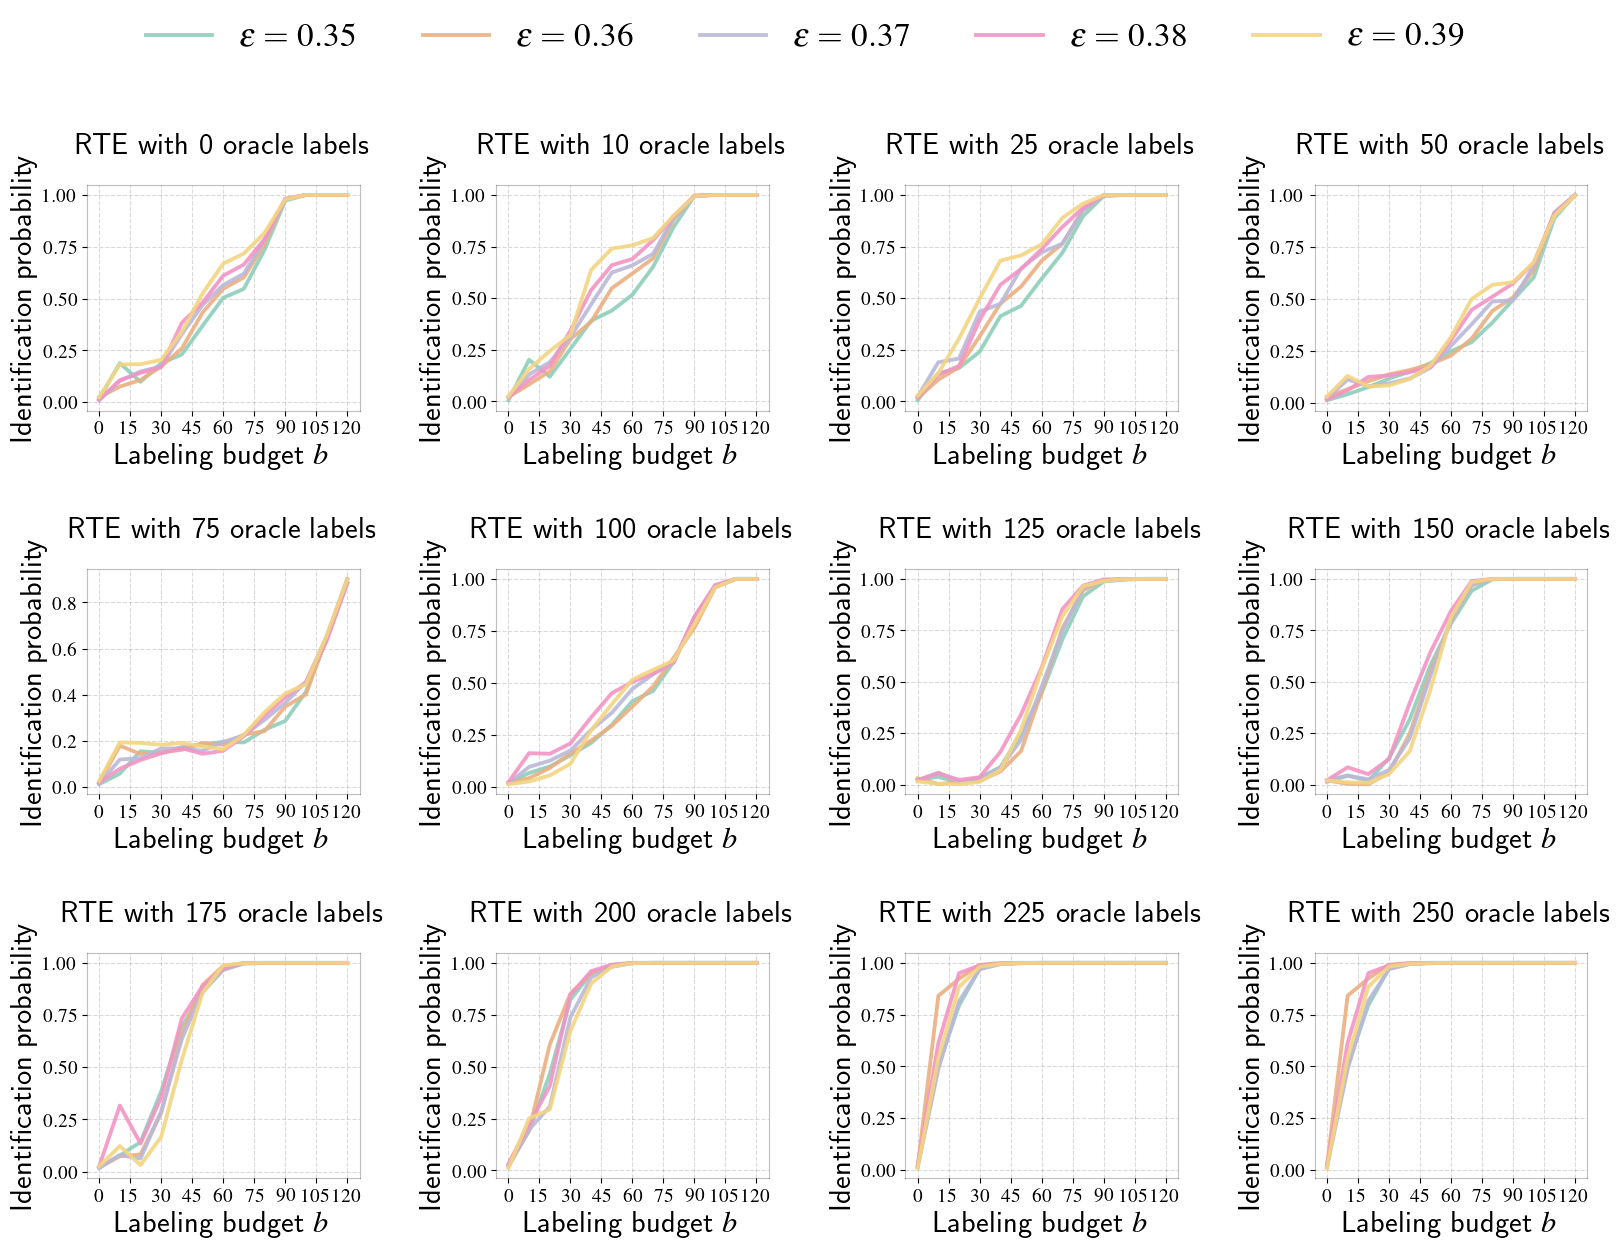

In [180]:
colors = plt.cm.Dark2(np.linspace(0, 1, 8))
colors = [make_pastel2(colors[0]),
          make_pastel2(colors[1]),
          make_pastel2(colors[2]),
          make_pastel2(colors[3]),
          make_pastel2(colors[-3]),
          make_pastel2(colors[-4])]

xtick = [-25.0, 0.0, 15.0, 30., 45.0, 60.0, 75., 90., 105., 120., 135.]

epsilon_range = ['0.35', '0.36', '0.37', '0.38', '0.39']

cutoff = 126

title = 'rte'

labels = {epsilon_range[0]: r'$\epsilon = 0.35$', 
          epsilon_range[1]: r'$\epsilon = 0.36$',
          epsilon_range[2]: r'$\epsilon = 0.37$',
          epsilon_range[3]: r'$\epsilon = 0.38$',
          epsilon_range[4]: r'$\epsilon = 0.39$'}



noisy_to_gt_rte_only = get_epsilon_results(path='path')
plot_noisy_to_gt(noisy_to_gt_rte_only, 'Identification probability', 'noisy_to_gt_rte.pdf', size=(16, 12), title=title, freq=10,
             xtick=xtick, labels=labels, colors=colors,
             cutoff=cutoff,
             epsilon_range=epsilon_range,
             grid_shape=(3, 4),
             )

# Labeling efficiency

In [394]:
CONFIDENCE = 1.00

def find_index_where_all_after_greater_than(arr, threshold=CONFIDENCE):
    # Iterate through the array to find the index
    for i in range(len(arr)):
        # if np.all(arr[i:] >= threshold):
        #     return i
        if arr[i] >= threshold or np.abs(arr[i] - threshold) <= 0.02:
            return i
    return len(arr) #

statistika = {}
statistika_percentage = {}
statistika_metoda = {}
mp = {}
arrow_line_index = {}
arrow_label = {}
arrow_label_percentrage = {}
for folder in one_shot_succ_prob.keys():
    statistika[folder] = []
    statistika_percentage[folder] = []
    for method in one_shot_succ_prob[folder].keys():
        if "Model" in method:
            if "domain_drift" in folder and '0.45' in method:
                continue   
            succ_prob = np.array(one_shot_succ_prob[folder][method])
            mp[folder] = (find_index_where_all_after_greater_than(succ_prob, CONFIDENCE))


for folder in one_shot_succ_prob.keys():
    print(folder)
    statistika[folder] = []
    statistika_percentage[folder] = []
    for method in one_shot_succ_prob[folder].keys():
        if "Model" in method:
            continue
        if method not in statistika_metoda.keys():
            statistika_metoda[method] = []
        
        succ_prob = np.array(one_shot_succ_prob[folder][method])
        ind =  find_index_where_all_after_greater_than(succ_prob, CONFIDENCE)
        statistika[folder].append(ind / mp[folder])
        statistika_percentage[folder].append(100 * (ind - mp[folder]) / ind)
        statistika_metoda[method].append(ind / mp[folder])
        
        if folder in arrow_line_index:
            arrow_line_index[folder] = (mp[folder], min(ind, arrow_line_index[folder][1]))
            arrow_label[folder] = min(arrow_label[folder], ind / mp[folder])
            arrow_label_percentrage[folder] = min(arrow_label_percentrage[folder], 100 * (ind - mp[folder]) / ind)
            
        else:
            arrow_line_index[folder] = (mp[folder], ind)
            arrow_label[folder] = ind / mp[folder]
            arrow_label_percentrage[folder] = 100 * (ind - mp[folder]) / ind

glue_cola
glue_mnli
imagenet_v2_top-images1k
glue_sst2
imagenet_v2_threshold-071k
glue_qnli
glue_qqp
imagenet1k
pacs
glue_rte
cifar10_4070
domain_drift
cifar10_5592
imagenet_v2_matched-frequency1k
emotion_detection
glue_mrpc
imagenet_pytorch_models1k
glue_wnli


# Tables & statistics

In [193]:
import pandas as pd
import re

def find_index_where_all_after_greater_than(arr, threshold=0.9):
    arr = np.array(arr)
    # Iterate through the array to find the index
    for i in range(len(arr)):
        # if np.all(arr[i:] >= threshold):
        if arr[i] >= threshold or np.abs(arr[i] - threshold) <= 0.02:
            return i
    return len(arr) - 1 #


# Define the row and column names
column_names = ['M-PICKER', 'RANDOM', 'MARGIN', 'UNCERTAINTY', 'AMC', 'VMA']
row_names = [
    'CIFAR10-High',
    'CIFAR10-Low',
    'EmoContext',
    'PACS',
    'Drift',
    'ImageNet',
    'ImageNet Pytorch',
    'ImageNetV2 T-I',
    'ImageNetV2 T-0.7',
    'ImageNetV2 M-F',
    'MRPC',
    'CoLA',
    'QNLI',
    'QQP',
    'SST-2',
    'WNLI',
    'MNLI',
    'RTE'
]

dataset_name_mapping = {
    'cifar10_4070': 'CIFAR10-Low',
    'cifar10_5592': 'CIFAR10-High',
    'domain_drift': 'Drift',
    'emotion_detection': 'EmoContext',
    'glue_cola': 'CoLA',
    'glue_mnli': 'MNLI',
    'glue_mrpc': 'MRPC',
    'glue_qnli': 'QNLI',
    'glue_qqp': 'QQP',
    'glue_rte': 'RTE',
    'glue_sst2': 'SST-2',
    'glue_wnli': 'WNLI',
    'imagenet1k': 'ImageNet',
    'imagenet_pytorch_models1k': 'ImageNet Pytorch',
    'imagenet_v2_matched-frequency1k': 'ImageNetV2 M-F',
    'imagenet_v2_threshold-071k': 'ImageNetV2 T-0.7',
    'imagenet_v2_top-images1k': 'ImageNetV2 T-I',
    'pacs': 'PACS'
}

method_name_mapping = {'Random': 'RANDOM',
                'QBC Entropy': 'UNCERTAINTY',
                'QBC Margin': 'MARGIN',
                "AMC": 'AMC',
                "VMA": 'VMA'
                }
# Initialize the DataFrame with a default value, e.g., None
df = pd.DataFrame(None, index=row_names, columns=column_names)

def create_confidence_mpicker_indices(one_shot_succ_prob):
    indices = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 1.00]:
        indices[threshold] = {}
        for dataset in accuracy_gap.keys():
            for method in accuracy_gap[dataset].keys():
                if "domain" in dataset and '0.45' in method:
                    continue
                if "Model" in method:
                    # print(threshold, dataset, method, find_index_where_all_after_greater_than(one_shot_succ_prob[dataset][method], threshold))
                    indices[threshold][dataset] = find_index_where_all_after_greater_than(one_shot_succ_prob[dataset][method], threshold)
    return indices
                
def get_table(threshold, indices, dictionary, latex=True, verbose=True, toprint=False):
    df = pd.DataFrame(None, index=row_names, columns=column_names)
    for dataset in dictionary.keys():
        for method in dictionary[dataset].keys():
            if "domain" in dataset and '0.45' in method:
                continue
            x = dictionary[dataset][method]
            ind = indices[threshold][dataset]
            row = dataset_name_mapping[dataset]
            column = method_name_mapping[method] if method in method_name_mapping.keys() else 'M-PICKER'
            df.loc[row, column] = x[ind] * 100
            
    pd.options.display.float_format = '{:.1f}'.format
    if not latex and toprint:
        print(df)
    else:
        latex_table = df.to_latex(index=True, float_format="%.1f")
        # latex_table = re.sub(r'([+-]?\d+\.\d+)e([+-]?\d+)', r'\1 \\times 10^{\2}', latex_table)
        # Print the LaTeX table
        if toprint:
            print(latex_table)
    min_columns = df.idxmin(axis=1)

    # Display which column has the minimum value for each row
    for index, column in min_columns.items():
        if verbose:
            print(f"Row {index} has minimum value in column: {column}")
    
    return df

def format_min_values(row):
    # Find the minimum and second minimum values
    sorted_row = row.sort_values()
    min_value = sorted_row.iloc[0]
    second_min_value = sorted_row.iloc[1]
    
    # Apply formatting
    row = row.apply(lambda x: f"\\textbf{{{x}}}" if x == min_value else (f"\\underline{{{x}}}" if x == second_min_value else x))
    return row
            
indices = create_confidence_mpicker_indices(one_shot_succ_prob)

In [231]:
# MAIN TABLE
threshold  = 0.7
tab1 = get_table(threshold, indices, percentile95_acc_gap, verbose=True, latex=False)
# print(tab1)
threshold = 0.8
tab2 = get_table(threshold, indices, percentile95_acc_gap, verbose=True, latex=False)
threshold = 0.9
tab3 = get_table(threshold, indices, percentile95_acc_gap, verbose=True, latex=False)
threshold = 1.00
tab4 = get_table(threshold, indices, percentile95_acc_gap, verbose=True, latex=False)
pd.options.display.float_format = '{:.2f}'.format  # Optional: for display formatting
def format_numeric_columns(df):
    return df.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

# Format each table
tab1 = format_numeric_columns(tab1)
tab2 = format_numeric_columns(tab2)
tab3 = format_numeric_columns(tab3)
tab4 = format_numeric_columns(tab4)

merged_df = tab1.astype(str) + '/' + tab2.astype(str) + '/' + tab3.astype(str) + '/' + tab4.astype(str)

print(merged_df.to_latex())

Row CIFAR10-High has minimum value in column: M-PICKER
Row CIFAR10-Low has minimum value in column: M-PICKER
Row EmoContext has minimum value in column: RANDOM
Row PACS has minimum value in column: M-PICKER
Row Drift has minimum value in column: M-PICKER
Row ImageNet has minimum value in column: M-PICKER
Row ImageNet Pytorch has minimum value in column: M-PICKER
Row ImageNetV2 T-I has minimum value in column: M-PICKER
Row ImageNetV2 T-0.7 has minimum value in column: M-PICKER
Row ImageNetV2 M-F has minimum value in column: M-PICKER
Row MRPC has minimum value in column: M-PICKER
Row CoLA has minimum value in column: M-PICKER
Row QNLI has minimum value in column: M-PICKER
Row QQP has minimum value in column: UNCERTAINTY
Row SST-2 has minimum value in column: M-PICKER
Row WNLI has minimum value in column: M-PICKER
Row MNLI has minimum value in column: M-PICKER
Row RTE has minimum value in column: M-PICKER
Row CIFAR10-High has minimum value in column: M-PICKER
Row CIFAR10-Low has minimum v

/tmp/ipykernel_13821/210710725.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)


In [194]:
# MAIN TABLE 90 percentile
def format_min_values(row):
    # Find the minimum and second minimum values
    sorted_row = row.sort_values()
    min_value = sorted_row.iloc[0]
    second_min_value = sorted_row.iloc[1]
    
    # Apply formatting
    row = row.apply(lambda x: f"\\textbf{{{x}}}" if x == min_value else (f"\\underline{{{x}}}" if x == second_min_value else x))
    return row

threshold  = 0.7
tab1 = get_table(threshold, indices, percentile90_acc_gap, verbose=True, latex=False)
# print(tab1)
threshold = 0.8
tab2 = get_table(threshold, indices, percentile90_acc_gap, verbose=True, latex=False)
threshold = 0.9
tab3 = get_table(threshold, indices, percentile90_acc_gap, verbose=True, latex=False)
threshold = 1.00
tab4 = get_table(threshold, indices, percentile90_acc_gap, verbose=True, latex=False)
pd.options.display.float_format = '{:.2f}'.format  # Optional: for display formatting
def format_numeric_columns(df):
    return df.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

# Format each table
tab1 = format_numeric_columns(tab1)
tab2 = format_numeric_columns(tab2)
tab3 = format_numeric_columns(tab3)
tab4 = format_numeric_columns(tab4)

tab1 = tab1.apply(format_min_values, axis=1)
tab2 = tab2.apply(format_min_values, axis=1)
tab3 = tab3.apply(format_min_values, axis=1)
tab4 = tab4.apply(format_min_values, axis=1)

pd.set_option('display.width', None)  # Set width to None for unlimited width
pd.set_option('display.max_columns', None)  # Show all columns without wrapping
merged_df = tab1.astype(str) + '/' + tab2.astype(str) + '/' + tab3.astype(str) + '/' + tab4.astype(str)

print(merged_df.to_latex())
print(merged_df)

Row CIFAR10-High has minimum value in column: M-PICKER
Row CIFAR10-Low has minimum value in column: M-PICKER
Row EmoContext has minimum value in column: M-PICKER
Row PACS has minimum value in column: M-PICKER
Row Drift has minimum value in column: RANDOM
Row ImageNet has minimum value in column: M-PICKER
Row ImageNet Pytorch has minimum value in column: M-PICKER
Row ImageNetV2 T-I has minimum value in column: M-PICKER
Row ImageNetV2 T-0.7 has minimum value in column: M-PICKER
Row ImageNetV2 M-F has minimum value in column: M-PICKER
Row MRPC has minimum value in column: M-PICKER
Row CoLA has minimum value in column: M-PICKER
Row QNLI has minimum value in column: M-PICKER
Row QQP has minimum value in column: UNCERTAINTY
Row SST-2 has minimum value in column: M-PICKER
Row WNLI has minimum value in column: M-PICKER
Row MNLI has minimum value in column: M-PICKER
Row RTE has minimum value in column: M-PICKER
Row CIFAR10-High has minimum value in column: M-PICKER
Row CIFAR10-Low has minimum v

/tmp/ipykernel_66221/2348751937.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)


# Label efficiency

In [182]:
path = 'path'


def find_index_when_satisfied(accuracy_at_budget, global_best_accuracy):
    
    global_best_accuracy = np.array(global_best_accuracy)
    
    indices = {}
    
    deltas = [0.05, 0.03, 0.02, 0.01, 0.005, 0.001]
    
    perc = 1 - accuracy_at_budget / global_best_accuracy[:, np.newaxis]
    
    
    for delta in deltas:
        where = (perc <= delta).astype(int)
        where = np.mean(where, axis=0)

        indices[delta] = np.argmax(where >= 1.00)
        
    return indices
        

label_efficeincy = {}

for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    
    
    res_file = 'experiment_result_additional.json' if not "imagenet" in folder else 'experiment_result.json'
    
    with open(os.path.join(folder_path, res_file), 'r') as f:
        data = json.load(f)
    res = ExperimentResult.from_json(data)
    
    config = ExperimentConfig.from_json_file(os.path.join(folder_path, 'config.json'))
    
    oracle, predictions, classes = load_dataset(os.path.join('path', config.dataset_path))
    
    label_efficeincy[folder] = {}
    
    # get GT
    realisations_results = np.zeros(len(res.realisations), dtype=object)
    for i, r in enumerate(res.realisations):
        # this calculates the model ranking for each realization pool, returns a tuple of model ranking and accuracies
        tmp = calculate_model_ranking(predictions[r], oracle[r]) 
        sorted_accuracies = np.sort(tmp[1])
        realisations_results[i] = *tmp, sorted_accuracies[::-1], sorted_accuracies
        
    
    print(folder)
    res.global_best_accuracy = np.array(res.global_best_accuracy)
    for model_selection_algorithm in tqdm(res.iteration_results.keys()):
        # create numpy arrays from saved lists
        res.iteration_results[model_selection_algorithm]["bestModelSelectedT"] = np.array(res.iteration_results[model_selection_algorithm]["bestModelSelectedT"])
        res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"] = np.array(res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"])
        
        
        label_efficeincy[folder][model_selection_algorithm] = find_index_when_satisfied(res.iteration_results[model_selection_algorithm]["bestModelAccuracyT"], res.global_best_accuracy)


INFO: Predictions are of type float64. Convert to int32.
glue_cola


100%|██████████| 6/6 [00:00<00:00, 17.45it/s]


INFO: Predictions are of type float64. Convert to int32.
glue_mnli


100%|██████████| 6/6 [00:00<00:00, 12.91it/s]


imagenet_v2_top-images1k


100%|██████████| 6/6 [00:00<00:00, 123.21it/s]


INFO: Predictions are of type float64. Convert to int32.
glue_sst2


100%|██████████| 6/6 [00:00<00:00, 17.91it/s]


imagenet_v2_threshold-071k


100%|██████████| 6/6 [00:00<00:00, 134.04it/s]


INFO: Predictions are of type float64. Convert to int32.
glue_qnli


100%|██████████| 6/6 [00:00<00:00, 13.07it/s]


INFO: Predictions are of type float64. Convert to int32.
glue_qqp


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


INFO: Classes start at 1 instead of 0. Adjusting dataset.
imagenet1k


100%|██████████| 6/6 [00:00<00:00, 132.32it/s]


pacs


100%|██████████| 6/6 [00:00<00:00, 13.02it/s]


INFO: Predictions are of type float64. Convert to int32.
glue_rte


100%|██████████| 6/6 [00:00<00:00, 49.95it/s]


cifar10_4070


100%|██████████| 6/6 [00:00<00:00, 13.42it/s]


INFO: Predictions are of type float64. Convert to int32.
INFO: Classes start at 1 instead of 0. Adjusting dataset.
domain_drift


100%|██████████| 7/7 [00:00<00:00, 17.58it/s]


cifar10_5592


100%|██████████| 6/6 [00:00<00:00, 13.43it/s]


imagenet_v2_matched-frequency1k


100%|██████████| 6/6 [00:00<00:00, 128.78it/s]


INFO: Predictions are of type float64. Convert to int32.
emotion_detection


100%|██████████| 6/6 [00:00<00:00, 12.85it/s]


INFO: Predictions are of type float64. Convert to int32.
glue_mrpc


100%|██████████| 6/6 [00:00<00:00, 35.39it/s]


imagenet_pytorch_models1k


100%|██████████| 6/6 [00:00<00:00, 133.12it/s]


INFO: Predictions are of type float64. Convert to int32.
glue_wnli


100%|██████████| 6/6 [00:00<00:00, 176.47it/s]


In [183]:
mp_ind = {}
for folder in label_efficeincy.keys():
    for method in label_efficeincy[folder].keys():
        if "Model" in method and 'domain_drift' in folder and '0.45' in method:
            continue
        if "Model" in method:
            mp_ind[folder] = label_efficeincy[folder][method]
    
divided = {}    
deltas = [0.05, 0.03, 0.02, 0.01, 0.005, 0.001]
for folder in label_efficeincy.keys():
    divided[folder] = {}
    for delta in deltas:
        divided[folder][delta] = []

for folder in label_efficeincy.keys():
    for method in label_efficeincy[folder].keys():
        if "Model" in method:
            continue 
        m = list(mp_ind[folder].keys())
        for delta in deltas:
            divided[folder][delta].append(label_efficeincy[folder][method][delta] / (mp_ind[folder][delta]))
            # print((mp_ind[folder][delta]))

In [ ]:
# MAIN TABLE
mp_ind = {}
for folder in label_efficeincy.keys():
    for method in label_efficeincy[folder].keys():
        if "Model" in method and 'domain_drift' in folder and '0.45' in method:
            continue
        if "Model" in method:
            mp_ind[folder] = label_efficeincy[folder][method]
    
divided = {}    
deltas = [0.05, 0.03, 0.02, 0.01, 0.005, 0.001]
percentage = {}
for folder in label_efficeincy.keys():
    divided[folder] = {}
    percentage[folder] = {}
    for delta in deltas:
        divided[folder][delta] = []
        percentage[folder][delta] = []

for folder in label_efficeincy.keys():
    for method in label_efficeincy[folder].keys():
        if "Model" in method:
            continue 
        m = list(mp_ind[folder].keys())
        for delta in deltas:
            divided[folder][delta].append(label_efficeincy[folder][method][delta] / (mp_ind[folder][delta]))
            percentage[folder][delta].append(((label_efficeincy[folder][method][delta] - mp_ind[folder][delta]) / max(label_efficeincy[folder][method][delta], mp_ind[folder][delta])) * 100)
            # print((mp_ind[folder][delta]))


mean_05 = []
stat = {}
percentage_stat = {}
keys = sorted(list(divided.keys()))
for folder in keys:
    for delta in divided[folder].keys():
        if delta not in stat:
            stat[delta] = []
        # if delta == 0.02: # or delta == 0.03:
        if delta == 0.05:
            continue
        if delta == 0.01:
            mean_05.append(np.min(divided[folder][delta]))
        print(folder, delta, np.min(divided[folder][delta])) #, divided[folder][delta])
        stat[delta].append(np.max(divided[folder][delta]))
        # else:
            # continue
    print()
 
# construct the dataframe and print it as latex       
print(np.mean(mean_05))        
for delta in stat.keys():
    print(delta, np.mean(stat[delta]))
    
column_names = list(divided['glue_qqp'].keys())
# create dataframe
df = pd.DataFrame(None, index=row_names, columns=column_names)
for folder in keys:
    for delta in divided[folder].keys():
        if "domain" in folder and '0.45' in method:
            continue
        # x = np.min(divided[folder][delta])
        x = np.min(percentage[folder][delta])        
        row = dataset_name_mapping[folder]
        column = delta
        df.loc[row, column] = x


def format_for_latex(x):
    arrow = ''
    if x > 0:
        arrow = '\\downarrow'
        res = f'\\textbf{{{x:.2f}}}\\%'
    elif x < 0:
        x = x * -1
        arrow = '\\uparrow'
        res = f'{x:.2f}\\%'
    else:
        res = f'{x:.2f}\\%'
    res = f"${arrow}{res}$"
    return res

# for appendix
df = df.drop(columns=[0.01, 0.005, 0.001], errors='ignore')
# latex_table = df.applymap(lambda x: f"${x:.2f}\\times$")
latex_table = df.applymap(format_for_latex)

# Convert dataframe to LaTeX format
latex_output = latex_table.to_latex(index=True)

# Dropping the column named '0.05'
pd.set_option('display.width', None)  # Set width to None for unlimited width
pd.set_option('display.max_columns', None)  # Show all columns without wrapping

print(latex_output)
print(df)